In [2]:
import numpy as np
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import cartopy.feature as cfeature
import cartopy
import matplotlib.pylab as pylab
import cartopy.feature as cfeature
from endgame import hist2d
import scipy.stats as stats
import xarray as xr
import ipdb
import glob
import itertools
import numpy.ma as ma
from utils import u_statistics as u_stat
from scipy.stats import gaussian_kde
import pickle as pkl
from utils import u_plot as uplot
import pandas as pd
from scipy.stats import gaussian_kde, linregress
import matplotlib.cm as cm
from utils import u_met
import seaborn
import metpy
from metpy import calc
from metpy.units import units
import statsmodels.api as sm
from scipy import ndimage
from matplotlib.ticker import (MultipleLocator, FormatStrFormatter,
                               AutoMinorLocator)
from scipy.stats import binned_statistic_2d

from numpy.polynomial import polynomial as P

##for regridding, install xesmf:
# conda install esmpy
# pip install xesmf
from utils import constants as cnst

pylab.rcParams['figure.figsize'] = (50., 50.)
%matplotlib inline

In [1]:
cd ..

/home/ck/pythonWorkspace/proj_CEH


Loads bulk statistics derived from having cut out storms (saved in MCSfiles), OBS includes rainfall from TRMM radar

In [3]:
def create_dic(dic):
    
    tt = np.array(dic['tmin'])
    mask = np.where(tt<=-50)
    
    pp = np.array(dic['pmax'])[mask]
    sh = np.array(dic['shear'])[mask] #np.array(dic['shear']) * (-1)
    umin = np.array(dic['u650'])[mask]
    umax = np.array(dic['u925'])[mask]
    qq = np.array(dic['q925'])[mask]
    qup = np.array(dic['q650'])[mask]
    tup = np.array(dic['t650'])[mask]
    tlow = np.array(dic['t925'])[mask]
    tt = np.array(dic['tmin'])[mask]
    ttm = np.array(dic['tmean'])[mask]
    month = np.array(dic['month'])[mask]
    hour = np.array(dic['hour'])[mask]
    year = np.array(dic['year'])[mask]
#    date = np.array(dic['date'])[mask]
    area = np.array(dic['area'])[mask]
    lat = np.array(dic['clat'])[mask]
    lon = np.array(dic['clon'])[mask]
    tcwv = np.array(dic['tcwv'])[mask]
  #  tgrad = np.array(dic['tgrad'])[mask]
  #  tbox = np.array(dic['tbox'])[mask]
    rh = np.array(dic['rh925'])[mask]
    pall = np.array(dic['p'])[mask]
    
    
    
#     p = units.Quantity(650, 'hPa')
#     t = units.Quantity(tup, 'K')
    
#     thetaes_up = np.array(calc.saturation_equivalent_potential_temperature(p,t))-273.15
#     #thetae_up = u_met.theta_e(650, tup-273.15, qup)


#     thetae_down_man = u_met.theta_e(925, tlow-273.15, qq)

#     p = units.Quantity(925, 'hPa')
#     t = units.Quantity(tlow, 'K')
#     q = units.Quantity(qq, 'kg/kg')
#     thetaes_down = np.array(calc.saturation_equivalent_potential_temperature(p,t))-273.15
#     dew = calc.dewpoint_from_specific_humidity(q, t, p)
#     thetae_down = np.array(calc.equivalent_potential_temperature(p,t,dew))-273.15
   
#     thetae = thetae_down - thetaes_up
#     thetaes = thetaes_down - thetaes_up
    
#     qdef = u_met.qdeficit(qq, tup, 650)
    
    #ipdb.set_trace()
    
#     if tgrad.ndim == 2:
#         tgrad = tlow
#     if tbox.ndim == 2:
#         tbox = tlow   ############## this is just to deal with tbox error

    obs_pcp = {
        'prcp' : pp+3,
        #'u650' : umin,
        #'u925' : umax,
        'q925' : qq*1000,
        'q650' : qup*1000,
        't925' : tlow-273.15,
        #'t650' : tup-273.15,
        'shear' : sh*-1,
        'month' : month,    
        'hour' : hour,
        'year' : year,
 #       'date' : date,
        'area' : (area)*(5**2),
        'tmin' : tt,
        'rh' : rh,
        #'tmean' : ttm,
        #'theta' : theta,
#         'theta_e' : thetae,
#         'theta_es' : thetaes,
        #'thup' : thetae_up,
        #'thdown' : thetae_down,
        'tcwv' : tcwv,
      #  'tgrad' : tgrad.squeeze(),
       # 'tbox' : tbox.squeeze(),
        'lat' : lat,
        'lon' : lon,
        'pall' : pall
    } 
    
    obs = pd.DataFrame(obs_pcp)
    return obs

In [4]:
def create_dic_model(dic):
    
    pp = np.array(dic['pmax'])
    sh = np.array(dic['shearmin']) #np.array(dic['shear']) * (-1)
    umin = np.array(dic['umin_mid'])
    umax = np.array(dic['umax_srfc'])
    qq = np.array(dic['qmax']) #+ 0.5
    tup = np.array(dic['tmidmax'])
    tcwv = np.array(dic['tcwv'])
  #  tgrad = np.array(dic['tgrad'])
   # tbox = np.array(dic['tdiff'])
    tt = np.array(dic['tmin'])
    ttm = np.array(dic['tmean'])
    month = np.array(dic['month'])
    tsrfc = np.array(dic['tsrfcmax']) #+ 3
    area = np.array(dic['area'])
    lat = np.array(dic['clat'])
    lon = np.array(dic['clon'])
    pall = np.array(dic['p'])

#     p = units.Quantity(650, 'hPa')
#     t = units.Quantity(tup+273.15, 'K')
    
#     thetaes_up = np.array(calc.saturation_equivalent_potential_temperature(p,t))
    
#     thetaes_up = []
#     ipdb.set_trace()
#     for tl in t:
#         try:
#             thetaa = float(np.array(calc.saturation_equivalent_potential_temperature(p,tl)))
#             thetaes_up.append(thetaa)
#             ipdb.set_trace()
#         except:
#             thetaes_up.append(np.nan)

#     thetaes_up = np.array(thetaes_up)

#     p = units.Quantity(925, 'hPa')
#     t = units.Quantity(tsrfc+273.15, 'K')
#     q = units.Quantity(qq/1000, 'kg/kg')
#     thetaes_down = np.array(calc.saturation_equivalent_potential_temperature(p,t))
#     dew = calc.dewpoint_from_specific_humidity(q, t, p)
#     thetae_down = np.array(calc.equivalent_potential_temperature(p,t,dew))
    
#     thetaes_down = []

#     for tl in t:
#         try:
#             thetaee = float(np.array(calc.saturation_equivalent_potential_temperature(p,tl)))
            
#             thetaes_down.append(thetaee)    
#         except:
#             thetaes_down.append(np.nan) 

#     thetaes_down = np.array(thetaes_down)  
    
#     thetaes = thetaes_down-thetaes_up  
#     thetae = thetae_down -thetaes_up  
#     qdef = u_met.qdeficit(qq/1000, tup+273.15, 650)
    
#     try:
#         thetamax = np.array(dic['thetamax'])
#         thetamean = np.array(dic['thetamean'])   
#     except:
#         pass

    obs_pcp = {
        'prcp' : pp+2,
        #'u650' : umin,
        #'u925' : umax,
        'q925' : qq,
        't925' : tsrfc,
        'tcwv' : tcwv,
       # 'tgrad' : tgrad,
        #'tbox' : tbox,
        'shear' : sh*-1,
        'month' : month,
        'area' : (area)*(4.4**2),
        'tmin' : tt,
        'tmean' : ttm,
        'lat' : lat,
        'lon' : lon,
#         'theta_es' : thetaes,
        'pall' : pall
    } 

#     try:
    #obs_pcp['theta_e']=thetae #+4
#         #obs_pcp['thetamean']=thetamean
#     except:
#         pass
    
    obs = pd.DataFrame(obs_pcp)
    return obs

In [5]:
ttag = 'hourly'
if ttag=='hourly':
    rres = 'means'
else:
    rres = '0.7deg'
cp4_histf = ('modelhist', cnst.CLOVER_SAVES + 'bulk_-50_5000km2_CP4'+rres+'_'+ttag+'_SAHEL_15kmprecip_WA_5-20N_-50C_TCWV_hist_*.p')
cp4_futf = ('modelfut' , cnst.CLOVER_SAVES + 'bulk_-50_5000km2_CP4'+rres+'_'+ttag+'_SAHEL_15kmprecip_WA_5-20N_-50C_TCWV_fut_*.p')
gpmf = ('obs' , cnst.CLOVER_SAVES + 'bulk_-50_5000km2_GPM_5-26N_16W17E_p15_ERA0.7_TCWV_'+ttag+'_*.p')
dlist = [cp4_histf,cp4_futf,gpmf]

In [6]:
for d in dlist:
    
    #ipdb.set_trace()
    ds = glob.glob(d[1])
    
    
    
    for ids, dss in enumerate(ds):
        data = pkl.load( open (dss, 'rb'))
        #data.update(dat)
        
        if 'model' in d[0]:
            if d[0] == 'modelhist':
                cp4_h = create_dic_model(data)
                if ids > 0:
                    histf = pd.concat([histf, cp4_h])
                else:
                    histf = cp4_h    
            else:
                cp4_f = create_dic_model(data)
                if ids > 0:
                    futf = pd.concat([futf, cp4_f])
                else:
                    futf = cp4_f
        if 'obs' in d[0]:
            if d[0] == 'obsm':
                obs_gpmc_m = create_dic(data)
                if ids > 0:
                    obs_gpmc = pd.concat([obs_gpmc, obs_gpmc_m])
                else:
                    obs_gpmc = obs_gpmc_m
            else:
                obs_gpmf_h = create_dic(data)
                if ids > 0:
                    obs_gpmf = pd.concat([obs_gpmf, obs_gpmf_h])
                else:
                    obs_gpmf = obs_gpmf_h
                    

        del data

/home/ck/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:19: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
/home/ck/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:27: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray


In [7]:
obs_gpmf.head()

,prcp,q925,q650,t925,shear,month,hour,year,area,tmin,rh,tcwv,lat,lon,pall
0,7.546894,15.324332,6.423853,24.874475,14.258469,7.0,17.0,2004.0,5975.0,-77.805445,72.686592,47.977135,16.581171,0.312186,"[0.16388519784114858, 0.16388519784114858, 0.0..."
1,46.385965,14.628493,5.576330,22.627802,17.359905,9.0,19.0,2004.0,83175.0,-75.000000,78.363197,47.305939,11.289606,-13.870493,"[0.262590098639102, 0.2989107209076306, 0.2937..."
2,23.520223,14.666178,6.573158,19.529047,4.076474,9.0,18.0,2004.0,60150.0,-76.466973,95.035973,53.804394,6.743863,-7.025343,"[0.0, 0.0, 0.0, 0.0, 0.1950280613061748, 0.304..."
3,11.098122,15.512402,5.839916,23.767664,5.012726,8.0,17.0,2004.0,7275.0,-73.380482,77.722290,50.499004,8.643763,10.914400,"[0.0, 0.0, 0.0, 0.0019483811340111794, 0.00387..."
4,23.549192,14.712868,4.529143,22.579614,11.788300,9.0,18.0,2004.0,6725.0,-76.211019,79.081085,42.870922,7.967304,-9.138874,"[0.11085381359510926, 0.0, 0.00333772859784012..."


In [8]:
data = pkl.load( open ('/home/ck/DIR/cornkle/data/CLOVER/saves/bulk_-50_5000km2_GPM_5-26N_16W17E_p15_ERA0.7_TCWV_hourly_wDate_2004.p', 'rb'))

In [9]:
data.keys()

dict_keys(['hour', 'month', 'year', 'day', 'date', 'area', 'lon', 'lat', 'clon', 'clat', 'minlon', 'minlat', 'tmin', 'tmean', 'tcwv', 'pmax', 'pmean', 'q925', 'q650', 'u925', 'u650', 'v925', 'v650', 'w925', 'w650', 'rh925', 'rh650', 't925', 't650', 'div925', 'div650', 'pv925', 'pv650', 'shear', 'pgt30', 'pgt01isvalid', 't', 'p', 'cape', 't2m'])

In [10]:
np.percentile(histf['tcwv'],0.5)  # 99.5 percentile

25.460361663990852

In [11]:
print(np.max(obs_gpmf.lat))
print(np.min(obs_gpmf.lat))
print(np.max(obs_gpmf.lon))
print(np.min(obs_gpmf.lon))

17.824957782145926
5.163266295264673
12.107882421128927
-16.97683096799293


In [12]:
tag = 'WA'
domainSA = [-10,12,5,8.5]
domainSS = [-10,12,11,18]#[-10,15,9,18]  # 8.5, 17.5
domainWA = [-10,12,6,17.5]
domainOuaga = [-4.5,2,11,13.5]  

nb = 23
if ttag == 'hourly':
    region = {'Sahel' : [domainSS, 'SoudanoSahel', np.linspace(9.5,17.8,nb) , np.linspace(3,24,nb), np.linspace(-10,10,nb), np.linspace(29,55,nb)], #TCW np.linspace(25,57,nb) #np.linspace(10,17.5,17) , np.linspace(0,25,17)  # monthly tcwv 30-50
              'Ouaga' : [domainOuaga, 'Ouaga', np.linspace(9.5,17.8,nb) , np.linspace(0,27,nb), np.linspace(-10,10,nb), np.linspace(25,57,nb)],
              'WA' : [domainWA, 'fullWA', np.linspace(11.5,19.5,nb), np.linspace(3,27,nb), np.linspace(-10,10,nb), np.linspace(20,92,nb)],
              'SWA' : [domainSA, 'southernWA', np.linspace(12.8,17.5,nb), np.linspace(0,25,nb), np.linspace(-10,10,nb), np.linspace(20,92,nb)],
             }
else:
    region = {'Sahel' : [domainSS, 'SoudanoSahel', np.linspace(9.5,17.8,nb) , np.linspace(7,18,nb), np.linspace(-10,10,nb), np.linspace(28,51,nb)], # 28,51 #np.linspace(10,17.5,17) , np.linspace(0,25,17)  # monthly tcwv 30-50
          'Ouaga' : [domainOuaga, 'Ouaga', np.linspace(9.5,17.8,nb) , np.linspace(0,27,nb), np.linspace(-10,10,nb), np.linspace(25,57,nb)],
          'WA' : [domainWA, 'fullWA', np.linspace(11.5,19.5,nb), np.linspace(3,27,nb), np.linspace(-10,10,nb), np.linspace(20,92,nb)],
          'SWA' : [domainSA, 'southernWA', np.linspace(12.8,17.5,nb), np.linspace(0,25,nb), np.linspace(-10,10,nb), np.linspace(20,92,nb)],
         }


domain = region[tag][0]
tname = region[tag][1]


m1 = 5#3
m2 =10#11
obs_gpm = obs_gpmf[(obs_gpmf.lon>=domain[0])&(obs_gpmf.lon<=domain[1])&(obs_gpmf.lat>=domain[2])&(obs_gpmf.lat<=domain[3])& (obs_gpmf.month>=m1) & (obs_gpmf.month<=m2)] #& (obs_gpm.month!=6) & (obs_gpm.month!=9)]
hist = histf[(histf.lon>=domain[0])&(histf.lon<=domain[1])&(histf.lat>=domain[2])&(histf.lat<=domain[3])& (histf.month>=m1) & (histf.month<=m2)]# & (histf.tbox<=10)]
fut = futf[(futf.lon>=domain[0])&(futf.lon<=domain[1])&(futf.lat>=domain[2])&(futf.lat<=domain[3])& (futf.month>=m1) & (futf.month<=m2)]# & (futf.tbox<=10)]


In [13]:
print('hist', hist.lat.min(), hist.lat.max(), hist.lon.min(), hist.lon.max())
print('OBS_gpm', obs_gpm.lat.min(), obs_gpm.lat.max(), obs_gpm.lon.min(), obs_gpm.lon.max())

hist 6.011251449584961 17.493003845214844 -9.980758666992188 11.990509033203125
OBS_gpm 6.000110895126605 17.497361776188868 -9.999745325933343 11.996942654145766


In [14]:
len(obs_gpm)

67084

In [15]:
oposi = (obs_gpm.q925>=8.) & (obs_gpm.shear>0) &  (obs_gpm.prcp>=8) & (obs_gpm.area>=5000) & (obs_gpm.tmin<=-55) # & ((obs_gpm.month>=9) | (obs_gpm.month<=5)) #0.1
cposi = (hist.q925>=8.) & (hist.shear>0) &  (hist.prcp>=8) & (np.isfinite(hist.q925)) & np.isfinite(hist.shear)  & (hist.area>=5000) & (hist.tmin<=-55)
fposi = (fut.q925>=8.) & (fut.shear>0) &  (fut.prcp>=8) & (np.isfinite(fut.q925)) & np.isfinite(fut.shear)  & (fut.area>=5000) & (fut.tmin<=-55)

In [16]:
obs = obs_gpm[oposi]
cp4 = hist[cposi]
cp4f = fut[fposi]
cp4.area = cp4.area.values

/home/ck/miniconda3/lib/python3.7/site-packages/pandas/core/generic.py:5168: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self[name] = value


In [17]:
np.percentile(obs.tcwv,99)

56.40317596435546

In [18]:
cp4.area.min()

5014.240000000001

In [19]:
obs.area.min()

5075.0

In [20]:
len(obs)

56694

In [21]:
len(cp4)

59615

In [22]:
len(cp4f)

45273

In [23]:
obs2 = obs[obs['tcwv']>45.5]

In [24]:
obs2['tcwv'].min()

45.500118255615234

In [25]:
obs['tcwv'].min()

22.560836791992188

/home/ck/miniconda3/lib/python3.7/site-packages/numpy/core/fromnumeric.py:3373: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/home/ck/miniconda3/lib/python3.7/site-packages/numpy/core/_methods.py:170: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/home/ck/miniconda3/lib/python3.7/site-packages/numpy/core/_methods.py:234: RuntimeWarning: Degrees of freedom <= 0 for slice
  keepdims=keepdims)
/home/ck/miniconda3/lib/python3.7/site-packages/numpy/core/_methods.py:195: RuntimeWarning: invalid value encountered in true_divide
  arrmean, rcount, out=arrmean, casting='unsafe', subok=False)
/home/ck/miniconda3/lib/python3.7/site-packages/numpy/core/_methods.py:226: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Text(0, 0.5, 'MCS number')

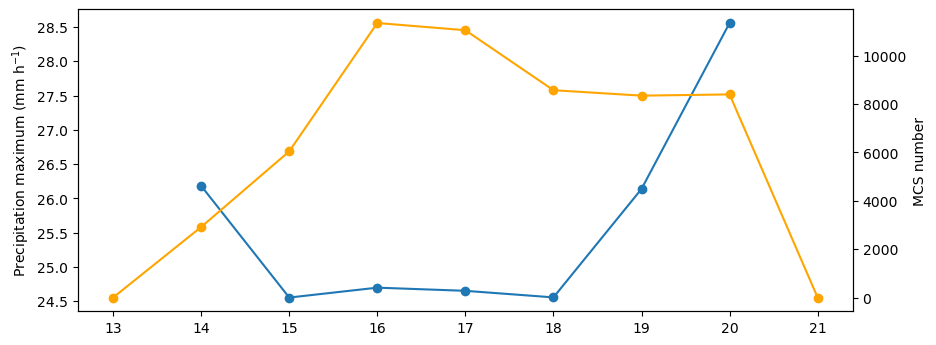

In [26]:
from endgame import hist2d
outdic = hist2d.var2_binning_mean(obs['hour'].values, obs['prcp'].values, np.array([13.5,14.5,15.5,16.5,17.5,18.5,19.5,20.5,21.5,22.5]))
#from scipy.ndimage import gaussian_filter1d
f= plt.figure(figsize=(10,4), dpi=100)
ax = f.add_subplot(111)
ax.plot(outdic['xbins']-1, outdic['y'], marker='o')
ax.set_ylabel('Precipitation maximum (mm h$^{-1}$)')
ax1 = ax.twinx()
ax1.plot(outdic['xbins']-1, outdic['ycount'], marker='o', color='orange')
ax1.set_ylabel('MCS number')

In [27]:
def moving_average(x, w):
    return np.convolve(x, np.ones(w), 'valid') / w

(-0.24637719585788473, 0.0)


Text(0.5, 0, 'MCS index')

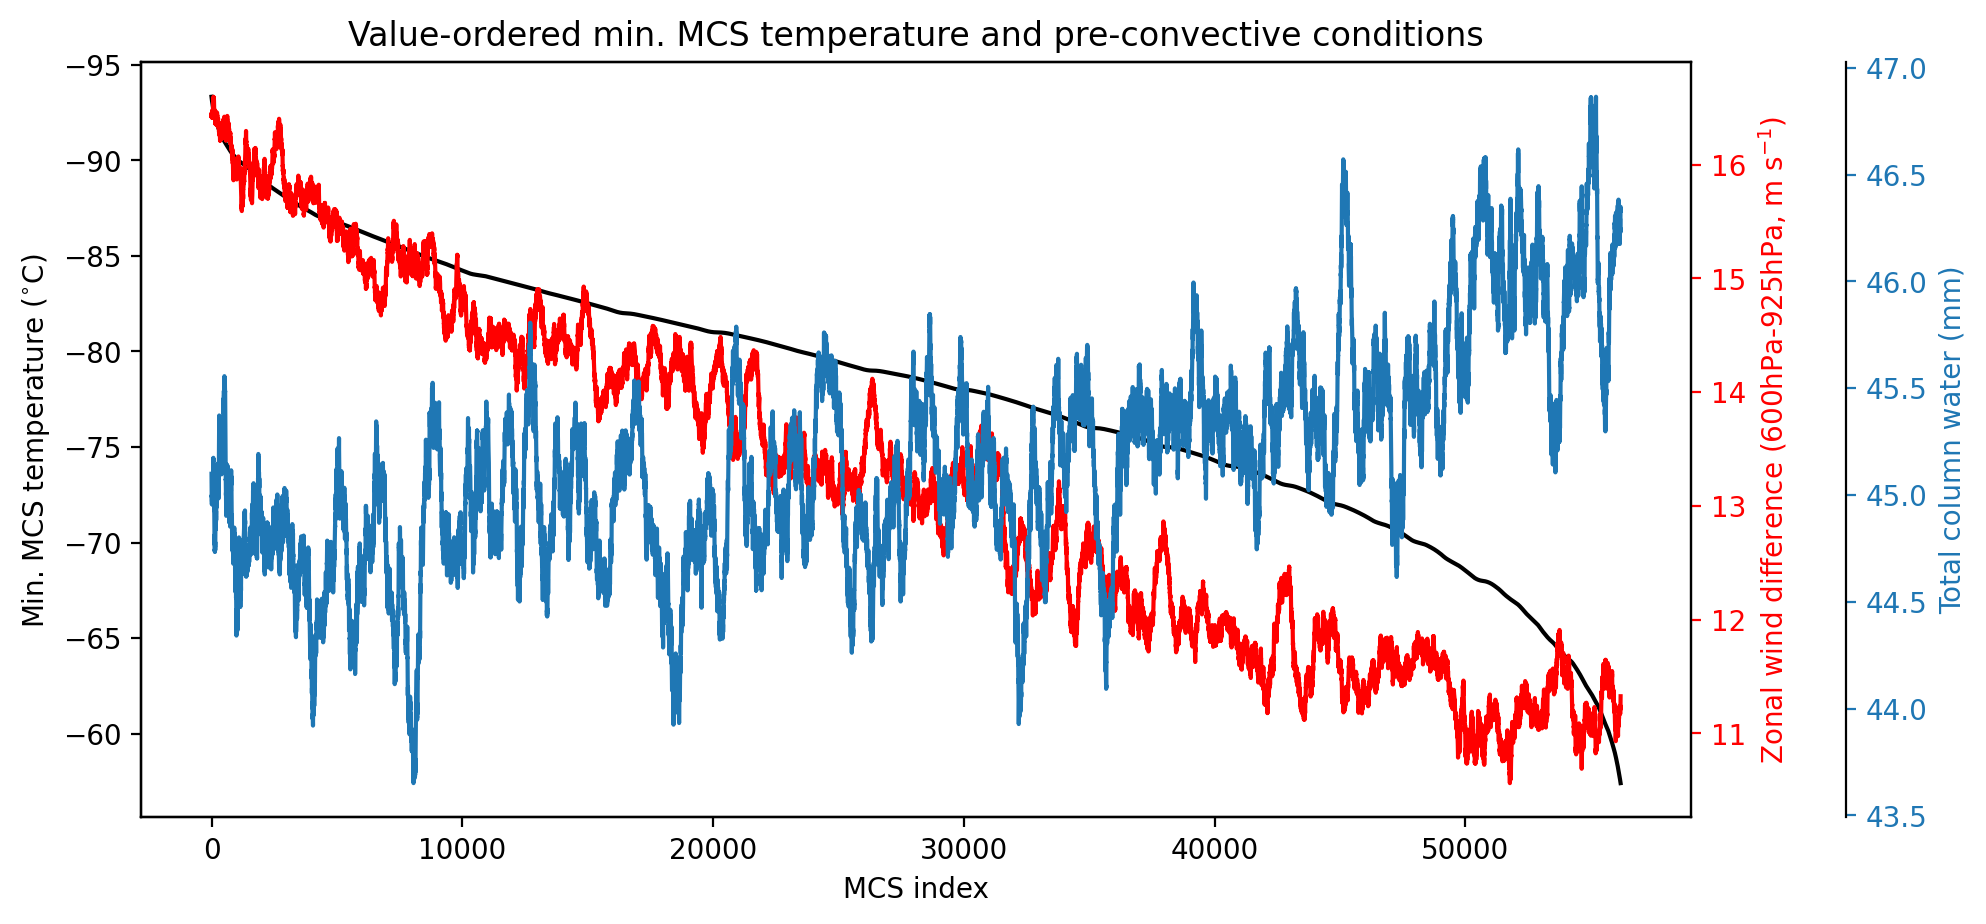

In [28]:
obsord = obs[np.isfinite(obs['prcp']) & np.isfinite(obs['shear']) & np.isfinite(obs['q925']) & np.isfinite(obs['t925'])]
inds = np.argsort(obsord['tmin'])

minus = -20000
pro = obsord['tmin'].values[inds]#[minus::]
sho = obsord['shear'].values[inds]#[minus::]
tco = obsord['tcwv'].values[inds]#[minus::]
qco = obsord['q925'].values[inds]#[minus::]
temp = obsord['t925'].values[inds]#[minus::]
qupco = obsord['q650'].values[inds]#[minus::]

f = plt.figure(figsize=(10,5), dpi=200)
ax = f.add_subplot(111)
ax2 = ax.twinx()
#ax3 = ax.twinx()
ax4 = ax.twinx()

agg = 500


# Offset the right spine of twin2.  The ticks and label have already been
# placed on the right by twinx above.
#ax2.spines["right"].set_position(("axes", 1.02))
#ax3.spines["right"].set_position(("axes", 1.1))
ax4.spines["right"].set_position(("axes", 1.1))

ax.plot(moving_average(pro,agg), label='prcp', color='k')
ax.invert_yaxis()

p4, = ax4.plot(moving_average(tco,agg), label='tcw')
p2, = ax2.plot(moving_average(sho,agg), label='shear', color='r')
#p3, = ax3.plot(moving_average(qco,500), label='q925', color='purple')
#p4, = ax4.plot(moving_average(temp,500), label='t925', color='orange')

ax2.yaxis.label.set_color(p2.get_color())
#ax3.yaxis.label.set_color(p3.get_color())
ax4.yaxis.label.set_color(p4.get_color())

tw = moving_average(tco,agg)
twd = tw[1::]-tw[0:-1]
sw = moving_average(sho,agg)
swd = sw[1::]-sw[0:-1]

print(stats.pearsonr(twd,swd))

ax.set_ylabel('Min. MCS temperature ($^{\circ}$C)')
ax2.set_ylabel('Zonal wind difference (600hPa-925hPa, m s$^{-1}$)')
ax4.set_ylabel('Total column water (mm)')


ax2.tick_params(axis='y', colors=p2.get_color())
#ax3.tick_params(axis='y', colors=p3.get_color() )
ax4.tick_params(axis='y', colors=p4.get_color())

ax.set_title('Value-ordered min. MCS temperature and pre-convective conditions')
ax.set_xlabel('MCS index')

#f.savefig('/home/ck/DIR/cornkle/figs/ENDGAME/ordered_MCSs/minT_ordered_15000.jpg')

(-0.24637719585788473, 0.0)


Text(0.5, 0, 'MCS index')

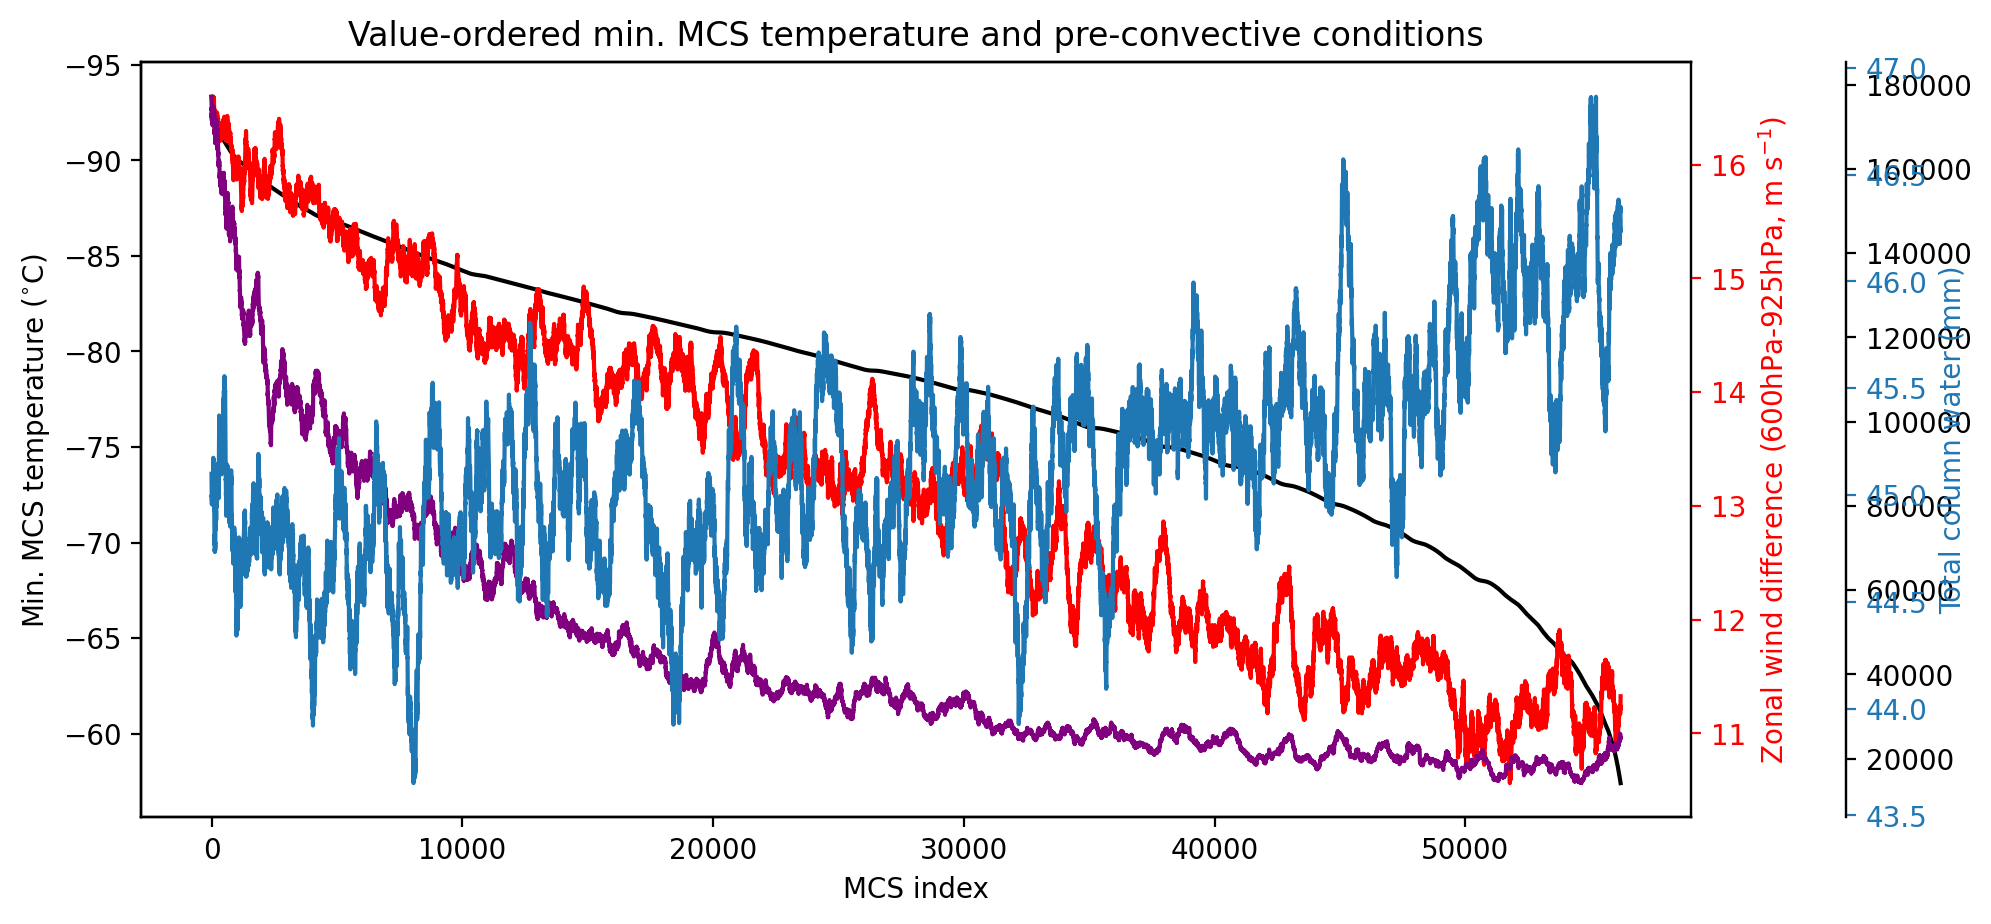

In [29]:
obsord = obs[np.isfinite(obs['prcp']) & np.isfinite(obs['shear']) & np.isfinite(obs['q925']) & np.isfinite(obs['t925'])]
inds = np.argsort(obsord['tmin'])

minus = -20000
pro = obsord['tmin'].values[inds]#[minus::]
sho = obsord['shear'].values[inds]#[minus::]
tco = obsord['tcwv'].values[inds]#[minus::]
qco = obsord['q925'].values[inds]#[minus::]
temp = obsord['t925'].values[inds]#[minus::]
qupco = obsord['area'].values[inds]#[minus::]

f = plt.figure(figsize=(10,5), dpi=200)
ax = f.add_subplot(111)
ax2 = ax.twinx()
ax3 = ax.twinx()
ax4 = ax.twinx()

agg = 500


# Offset the right spine of twin2.  The ticks and label have already been
# placed on the right by twinx above.
#ax2.spines["right"].set_position(("axes", 1.02))
#ax3.spines["right"].set_position(("axes", 1.1))
ax4.spines["right"].set_position(("axes", 1.1))
ax3.spines["right"].set_position(("axes", 1.1))

ax.plot(moving_average(pro,agg), label='prcp', color='k')
ax.invert_yaxis()
p4, = ax4.plot(moving_average(tco,agg), label='tcw')
p2, = ax2.plot(moving_average(sho,agg), label='shear', color='r')
p3, = ax3.plot(moving_average(qupco,agg), label='storm area', color='purple')
#p4, = ax4.plot(moving_average(temp,500), label='t925', color='orange')

ax2.yaxis.label.set_color(p2.get_color())
#ax3.yaxis.label.set_color(p3.get_color())
ax4.yaxis.label.set_color(p4.get_color())

tw = moving_average(tco,agg)
twd = tw[1::]-tw[0:-1]
sw = moving_average(sho,agg)
swd = sw[1::]-sw[0:-1]

print(stats.pearsonr(twd,swd))

ax.set_ylabel('Min. MCS temperature ($^{\circ}$C)')
ax2.set_ylabel('Zonal wind difference (600hPa-925hPa, m s$^{-1}$)')
ax4.set_ylabel('Total column water (mm)')


ax2.tick_params(axis='y', colors=p2.get_color())
#ax3.tick_params(axis='y', colors=p3.get_color() )
ax4.tick_params(axis='y', colors=p4.get_color())

ax.set_title('Value-ordered min. MCS temperature and pre-convective conditions')
ax.set_xlabel('MCS index')

#f.savefig('/home/ck/DIR/cornkle/figs/ENDGAME/ordered_MCSs/minT_ordered_15000.jpg')

(-0.26883689496991064, 0.0)


NameError: name 'gauss' is not defined

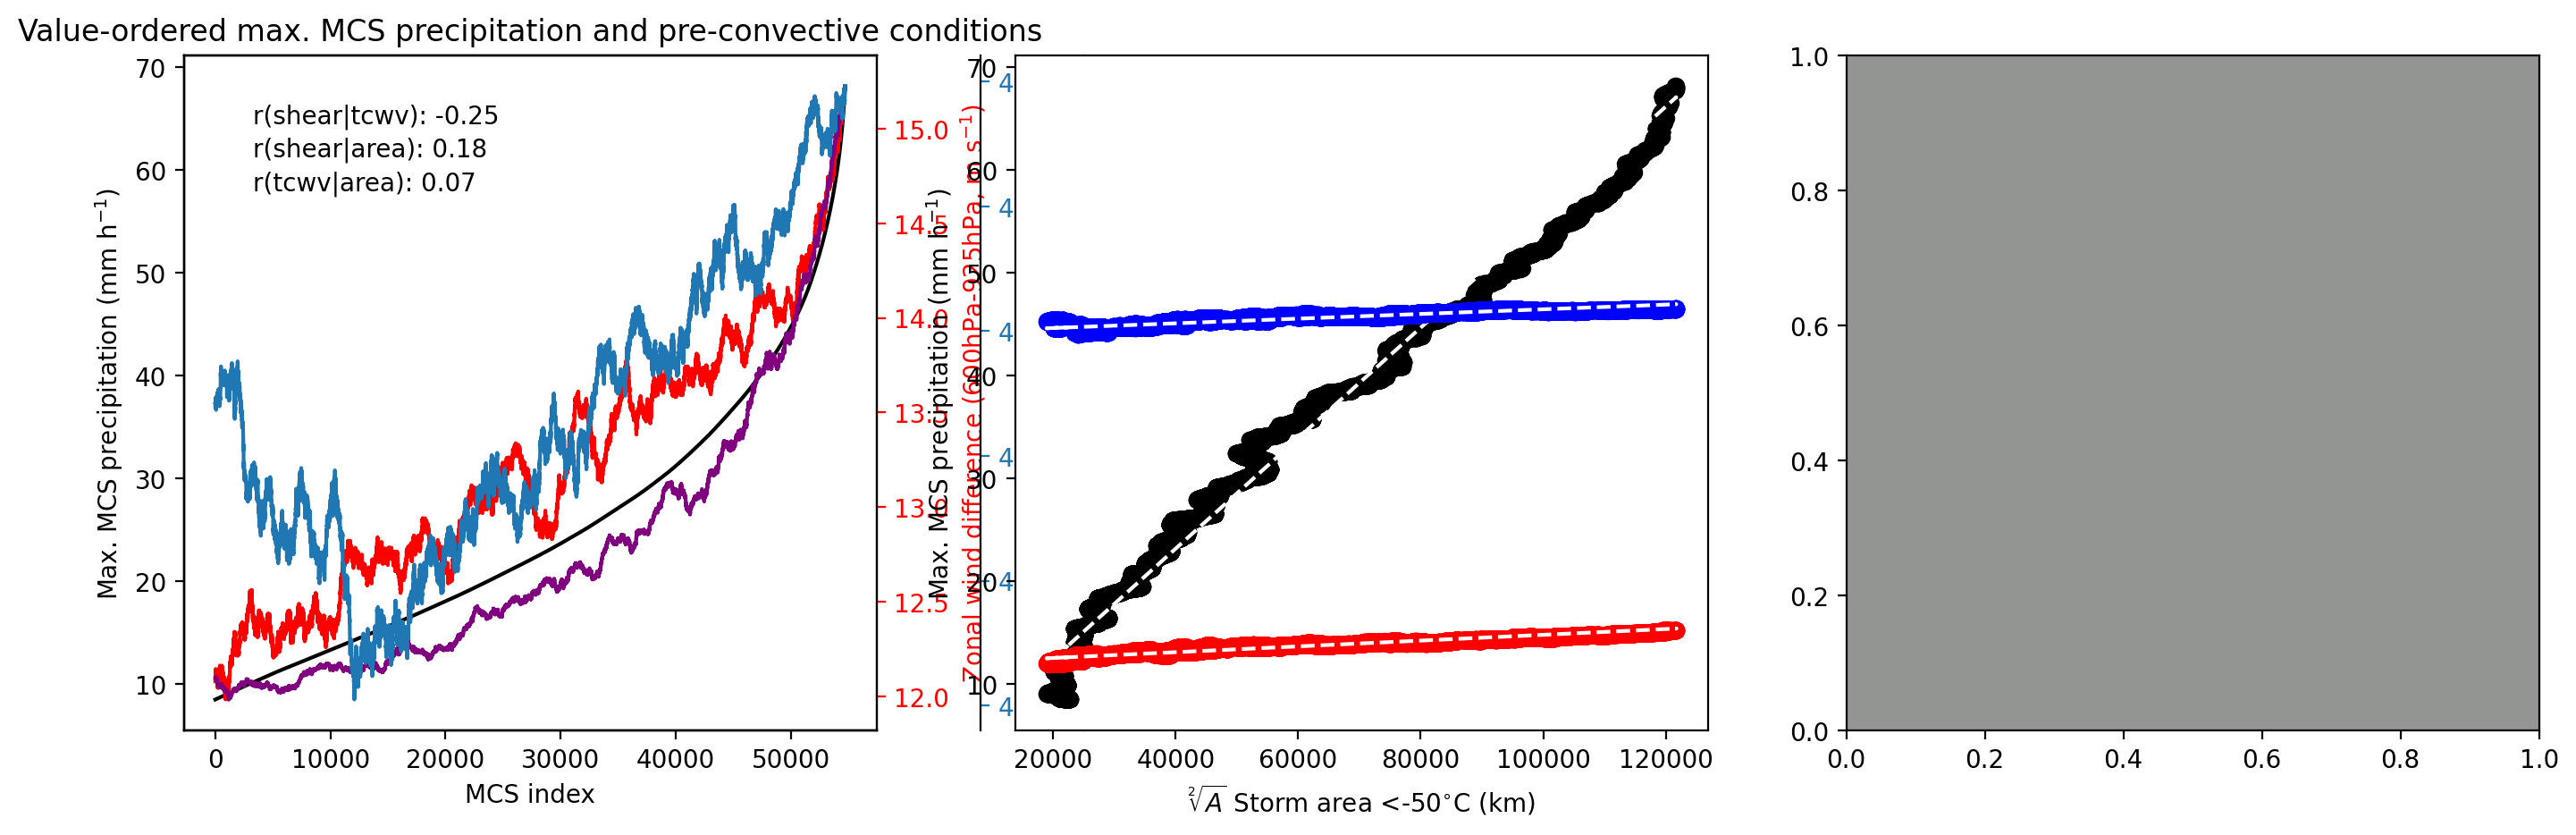

In [30]:
obsord = obs[np.isfinite(obs['tmin']) & np.isfinite(obs['shear']) & np.isfinite(obs['q925']) & np.isfinite(obs['t925'])]
inds = np.argsort(obsord['prcp'])

minus = -20000
pro = obsord['prcp'].values[inds]#[minus::]
sho = obsord['shear'].values[inds]#[minus::]
tco = obsord['tcwv'].values[inds]#[minus::]
qco = obsord['q925'].values[inds]#[minus::]
temp = obsord['t925'].values[inds]#[minus::]
qupco = obsord['area'].values[inds]#[minus::]

f = plt.figure(figsize=(17,5), dpi=200)
ax = f.add_subplot(131)
ax2 = ax.twinx()
ax3 = ax.twinx()
ax4 = ax.twinx()

agg = 2000


# Offset the right spine of twin2.  The ticks and label have already been
# placed on the right by twinx above.
#ax2.spines["right"].set_position(("axes", 1.02))
ax3.spines["right"].set_position(("axes", 1.3))
ax4.spines["right"].set_position(("axes", 1.15))

ax.plot(moving_average(pro,agg), label='prcp', color='k')

p4, = ax4.plot(moving_average(tco,agg), label='tcw')
p2, = ax2.plot(moving_average(sho,agg), label='shear', color='r')
p3, = ax3.plot(moving_average(qupco,agg), label='area', color='purple')
#p4, = ax4.plot(moving_average(temp,500), label='t925', color='orange')

ax2.yaxis.label.set_color(p2.get_color())
ax3.yaxis.label.set_color(p3.get_color())
ax4.yaxis.label.set_color(p4.get_color())

tw = moving_average(tco,agg)
twd = tw[1::]-tw[0:-1]
sw = moving_average(sho,agg)
swd = sw[1::]-sw[0:-1]

print(stats.pearsonr(twd,swd))

ax.set_ylabel('Max. MCS precipitation (mm h$^{-1}$)')
ax2.set_ylabel('Zonal wind difference (600hPa-925hPa, m s$^{-1}$)')
ax4.set_ylabel('Total column water (mm)')
ax3.set_ylabel(r'Storm area <-50$^{\circ}$C (km$^2$)')


ax2.tick_params(axis='y', colors=p2.get_color())
ax3.tick_params(axis='y', colors=p3.get_color() )
ax4.tick_params(axis='y', colors=p4.get_color())


ax.text(0.1,0.9, 'r(shear|tcwv): '+str(np.round(stats.pearsonr(sho,tco)[0],2)), transform=ax.transAxes)
ax.text(0.1,0.85, 'r(shear|area): '+str(np.round(stats.pearsonr(sho,qupco)[0],2)), transform=ax.transAxes)
ax.text(0.1,0.8, 'r(tcwv|area): '+str(np.round(stats.pearsonr(tco,qupco)[0],2)), transform=ax.transAxes)

ax.set_title('Value-ordered max. MCS precipitation and pre-convective conditions')
ax.set_xlabel('MCS index')

ax = f.add_subplot(1,3,2)

x = moving_average(qupco,agg)  #np.sqrt(
y = moving_average(pro,agg)
z = moving_average(sho,agg)
zz = moving_average(tco,agg)

#ax.scatter(np.sqrt(moving_average(qupco,agg)),moving_average(pro,agg))
m, b = np.polyfit(x, y, 1)
ax.plot(x,y,'ko', x, m*x+b, '--w')

m, b = np.polyfit(x, z, 1)
ax.plot(x,z,'ro', x, m*x+b, '--w')

m, b = np.polyfit(x, zz, 1)
ax.plot(x,zz,'bo', x, m*x+b, '--w')

plt.ylabel('Max. MCS precipitation (mm h$^{-1}$)')
plt.xlabel(r'$\sqrt[2]{A}$ Storm area <-50$^{\circ}$C (km)')


#######################################


cmap='Blues'
vmins = 35
vmaxs = 60
pixelval = 10
cmapp = uplot.discrete_cmap(10, base_cmap=cmap)
cmapp.set_over("black")
ax = f.add_subplot(1,3,3)
ax.set_facecolor('xkcd:grey')
dd = gauss(ret.statistic.T, 0.8)
invalid = count.statistic.T < pixelval
dd[invalid] = np.nan
bigpos = np.where(dd>60)
print('bigpos', bigpos)
mp = plt.pcolormesh(testbins[0], testbins[1], dd, cmap=cmapp, vmin=vmins, vmax=vmaxs)
#plt.plot(testbins[0][bigpos[1]+1],testbins[1][bigpos[0]+1], 'o', color='grey', ms=1)

plt.xlabel('Storm area <-50$^{\circ}$C (km$^2$)')
plt.ylabel('Zonal wind shear (650-925hPa, m s$^{-1}$)')
#plt.text(1,56, r'r$^2$ = '+str(np.round(dicobs['model'].rsquared,2)), fontsize=10)
plt.title('Observations (Meteosat, GPM, ERA5): Maximum MCS rainfall')

cbar = plt.colorbar(mp, ticks=np.linspace(vmins, vmaxs,11), extend='max')
cbar.set_label('mm h$^{-1}$')

# ax = f.add_subplot(1,2,2)
# ax.set_facecolor('xkcd:grey')
# dd = gauss(ret4.statistic.T, 0.7)
# invalid = count4.statistic.T < pixelval
# dd[invalid] = np.nan
# cmapp.set_over("black")
# mp = plt.pcolormesh(testbins[0], testbins[1], dd, cmap=cmapp, vmin=vmins, vmax=vmaxs)
# cbar = plt.colorbar(mp, ticks=np.linspace(vmins,vmaxs,11), extend='max')
# cbar.set_label('mm h$^{-1}$')

# plt.xlabel('Storm area <-50$^{\circ}$C (km$^2$)')
# plt.ylabel('Zonal wind shear (650-925hPa, m s$^{-1}$)')

# plt.title('CP4 model: Maximum MCS rainfall')

plt.tight_layout()

#f.savefig('/home/ck/DIR/cornkle/figs/ENDGAME/ordered_MCSs/minT_ordered_withP_15000.jpg')


(-0.2752398711719079, 0.0)
bigpos (array([11, 11, 12, 12, 12, 12, 12, 13, 13, 15, 16, 16, 17, 17, 17, 17, 17,
       18, 18, 18, 18, 18, 18, 18, 19]), array([18, 19, 18, 19, 20, 21, 22, 21, 22, 17, 17, 22,  8, 16, 20, 21, 22,
        8, 16, 20, 21, 22, 23, 25, 24]))


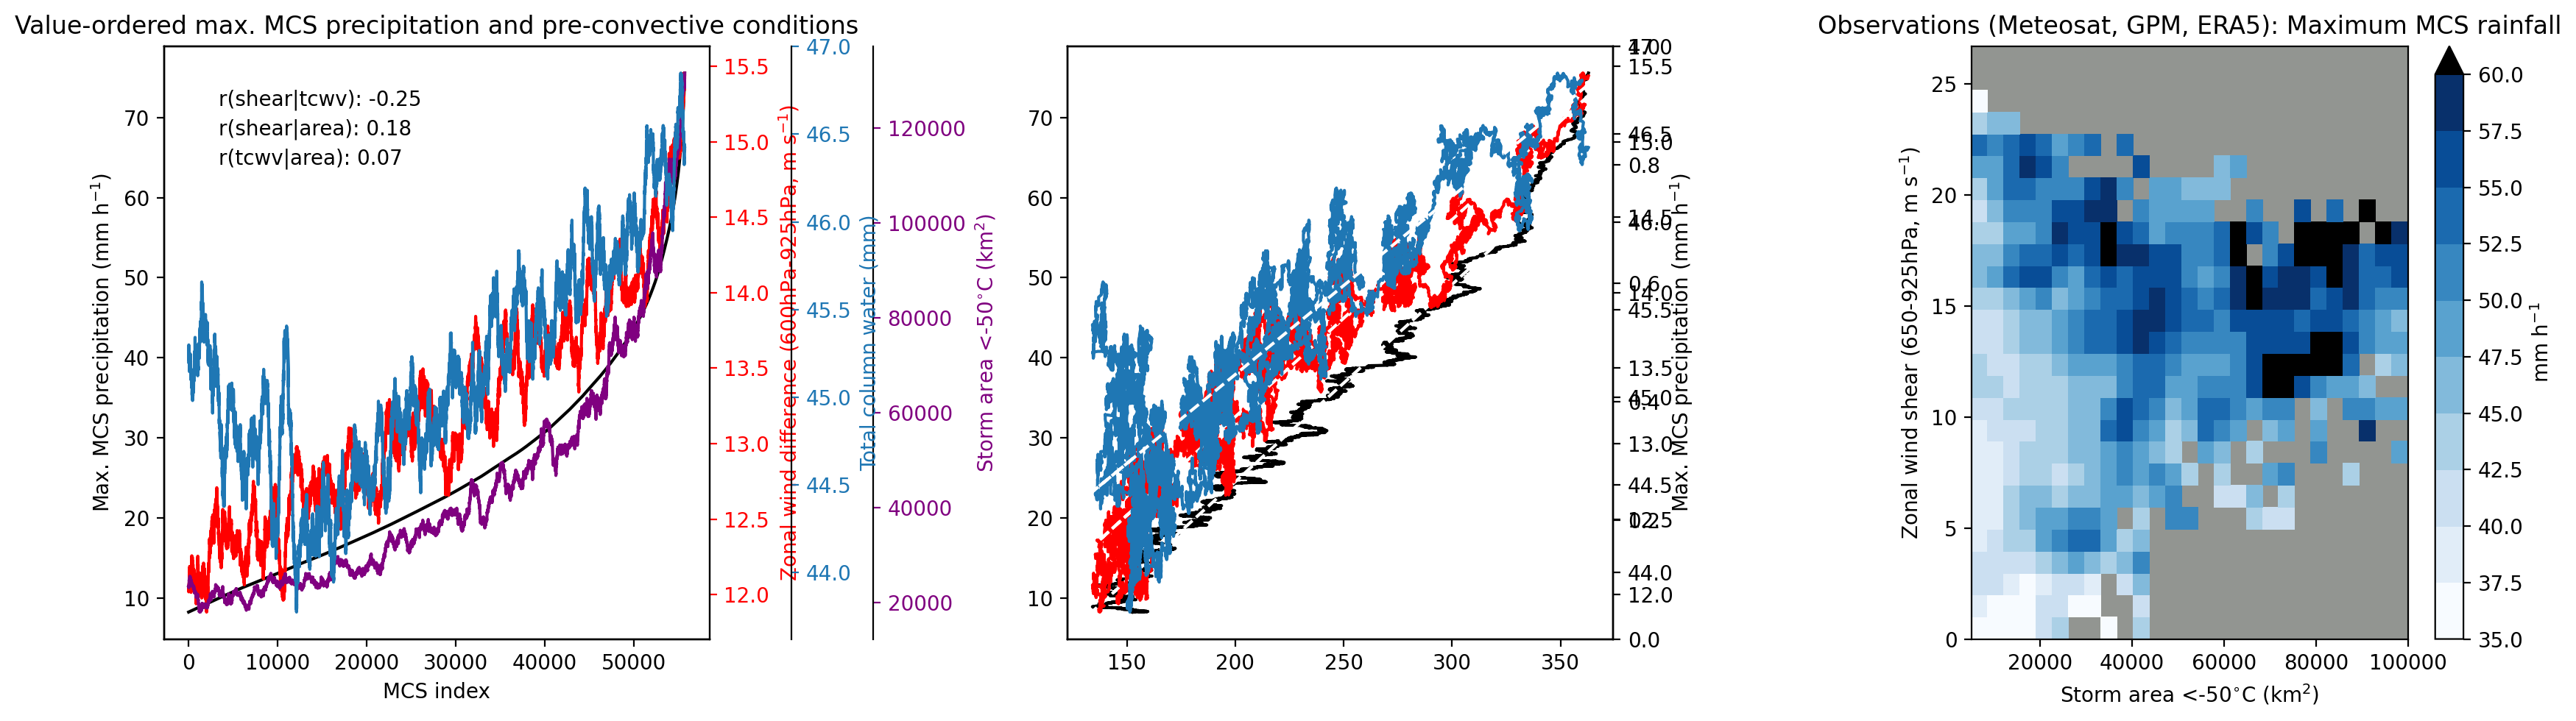

In [295]:
obsord = obs[np.isfinite(obs['tmin']) & np.isfinite(obs['shear']) & np.isfinite(obs['q925']) & np.isfinite(obs['t925'])]
inds = np.argsort(obsord['prcp'])

minus = -20000
pro = obsord['prcp'].values[inds]#[minus::]
sho = obsord['shear'].values[inds]#[minus::]
tco = obsord['tcwv'].values[inds]#[minus::]
qco = obsord['q925'].values[inds]#[minus::]
temp = obsord['t925'].values[inds]#[minus::]
qupco = obsord['area'].values[inds]#[minus::]

f = plt.figure(figsize=(17,5), dpi=200)
ax = f.add_subplot(131)
ax2 = ax.twinx()
ax3 = ax.twinx()
ax4 = ax.twinx()

agg = 1000


# Offset the right spine of twin2.  The ticks and label have already been
# placed on the right by twinx above.
#ax2.spines["right"].set_position(("axes", 1.02))
ax3.spines["right"].set_position(("axes", 1.3))
ax4.spines["right"].set_position(("axes", 1.15))

ax.plot(moving_average(pro,agg), label='prcp', color='k')

p4, = ax4.plot(moving_average(tco,agg), label='tcw')
p2, = ax2.plot(moving_average(sho,agg), label='shear', color='r')
p3, = ax3.plot(moving_average(qupco,agg), label='area', color='purple')
#p4, = ax4.plot(moving_average(temp,500), label='t925', color='orange')

ax2.yaxis.label.set_color(p2.get_color())
ax3.yaxis.label.set_color(p3.get_color())
ax4.yaxis.label.set_color(p4.get_color())

tw = moving_average(tco,agg)
twd = tw[1::]-tw[0:-1]
sw = moving_average(sho,agg)
swd = sw[1::]-sw[0:-1]

print(stats.pearsonr(twd,swd))

ax.set_ylabel('Max. MCS precipitation (mm h$^{-1}$)')
ax2.set_ylabel('Zonal wind difference (600hPa-925hPa, m s$^{-1}$)')
ax4.set_ylabel('Total column water (mm)')
ax3.set_ylabel(r'Storm area <-50$^{\circ}$C (km$^2$)')


ax2.tick_params(axis='y', colors=p2.get_color())
ax3.tick_params(axis='y', colors=p3.get_color() )
ax4.tick_params(axis='y', colors=p4.get_color())


ax.text(0.1,0.9, 'r(shear|tcwv): '+str(np.round(stats.pearsonr(sho,tco)[0],2)), transform=ax.transAxes)
ax.text(0.1,0.85, 'r(shear|area): '+str(np.round(stats.pearsonr(sho,qupco)[0],2)), transform=ax.transAxes)
ax.text(0.1,0.8, 'r(tcwv|area): '+str(np.round(stats.pearsonr(tco,qupco)[0],2)), transform=ax.transAxes)

ax.set_title('Value-ordered max. MCS precipitation and pre-convective conditions')
ax.set_xlabel('MCS index')

ax = f.add_subplot(1,3,2)

ax2 = ax.twinx()
ax3 = ax.twinx()
ax4 = ax.twinx()

x = np.sqrt(moving_average(qupco,agg))  #np.sqrt(
y = moving_average(pro,agg)
z = moving_average(sho,agg)
zz = moving_average(tco,agg)

m, b = np.polyfit(x, y, 1)
ax.plot(x,y,'k', x, m*x+b, '--w')

m, b = np.polyfit(x, z, 1)
ax2.plot(x,z,'r', x, m*x+b, '--w')

m, b = np.polyfit(x, zz, 1)
ax3.plot(x,zz,'', x, m*x+b, '--w')

plt.ylabel('Max. MCS precipitation (mm h$^{-1}$)')
plt.xlabel(r'$\sqrt[2]{A}$ Storm area <-50$^{\circ}$C (km)')


#######################################


cmap='Blues'
vmins = 35
vmaxs = 60
pixelval = 10
cmapp = uplot.discrete_cmap(10, base_cmap=cmap)
cmapp.set_over("black")
ax = f.add_subplot(1,3,3)
ax.set_facecolor('xkcd:grey')
dd = gauss(ret.statistic.T, 0.8)
invalid = count.statistic.T < pixelval
dd[invalid] = np.nan
bigpos = np.where(dd>60)
print('bigpos', bigpos)
mp = plt.pcolormesh(testbins[0], testbins[1], dd, cmap=cmapp, vmin=vmins, vmax=vmaxs)
#plt.plot(testbins[0][bigpos[1]+1],testbins[1][bigpos[0]+1], 'o', color='grey', ms=1)

plt.xlabel('Storm area <-50$^{\circ}$C (km$^2$)')
plt.ylabel('Zonal wind shear (650-925hPa, m s$^{-1}$)')
#plt.text(1,56, r'r$^2$ = '+str(np.round(dicobs['model'].rsquared,2)), fontsize=10)
plt.title('Observations (Meteosat, GPM, ERA5): Maximum MCS rainfall')

cbar = plt.colorbar(mp, ticks=np.linspace(vmins, vmaxs,11), extend='max')
cbar.set_label('mm h$^{-1}$')

# ax = f.add_subplot(1,2,2)
# ax.set_facecolor('xkcd:grey')
# dd = gauss(ret4.statistic.T, 0.7)
# invalid = count4.statistic.T < pixelval
# dd[invalid] = np.nan
# cmapp.set_over("black")
# mp = plt.pcolormesh(testbins[0], testbins[1], dd, cmap=cmapp, vmin=vmins, vmax=vmaxs)
# cbar = plt.colorbar(mp, ticks=np.linspace(vmins,vmaxs,11), extend='max')
# cbar.set_label('mm h$^{-1}$')

# plt.xlabel('Storm area <-50$^{\circ}$C (km$^2$)')
# plt.ylabel('Zonal wind shear (650-925hPa, m s$^{-1}$)')

# plt.title('CP4 model: Maximum MCS rainfall')

plt.tight_layout()

#f.savefig('/home/ck/DIR/cornkle/figs/ENDGAME/ordered_MCSs/minT_ordered_withP_15000.jpg')

(-0.2598203399928774, 0.0)


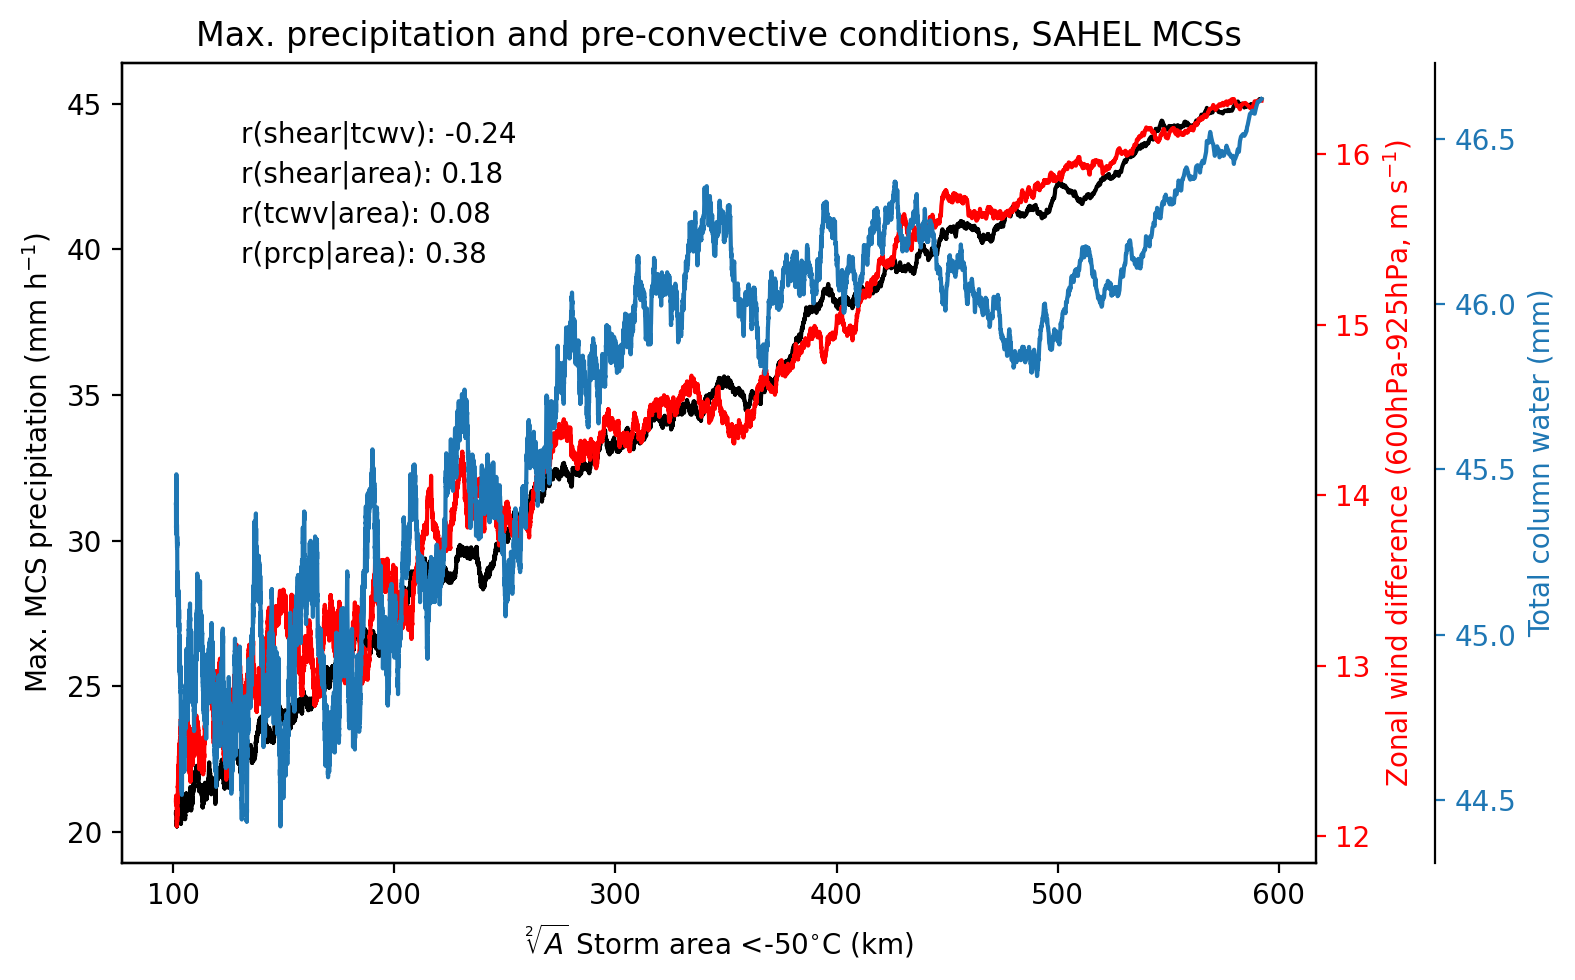

In [44]:
obsord = obs[np.isfinite(obs['tmin']) & np.isfinite(obs['shear']) & np.isfinite(obs['q925']) & np.isfinite(obs['t925']) & (np.sqrt(obs['area'])>100)]
inds = np.argsort(obsord['area'])

minus = -20000
pro = obsord['prcp'].values[inds]#[minus::]
sho = obsord['shear'].values[inds]#[minus::]
tco = obsord['tcwv'].values[inds]#[minus::]
qco = obsord['q925'].values[inds]#[minus::]
temp = obsord['t925'].values[inds]#[minus::]
qupco = obsord['area'].values[inds]#[minus::]

f = plt.figure(figsize=(8,5), dpi=200)
ax = f.add_subplot(111)
ax2 = ax.twinx()
#ax3 = ax.twinx()
ax4 = ax.twinx()

agg = 1000


# Offset the right spine of twin2.  The ticks and label have already been
# placed on the right by twinx above.
ax2.spines["right"].set_position(("axes", 1))
#ax3.spines["right"].set_position(("axes", 1.3))
ax4.spines["right"].set_position(("axes", 1.1))

x = np.sqrt(moving_average(qupco,agg))  #np.sqrt(
y = moving_average(pro,agg)
z = moving_average(sho,agg)
zz = moving_average(tco,agg)


ax.plot(x,y, label='prcp', color='k')

p4, = ax4.plot(x,zz, label='TCW')
p2, = ax2.plot(x,z, label='shear', color='r')
#p3, = ax3.plot(moving_average(qupco,agg), label='area', color='purple')
#p4, = ax4.plot(moving_average(temp,500), label='t925', color='orange')

ax2.yaxis.label.set_color(p2.get_color())
#ax3.yaxis.label.set_color(p3.get_color())
ax4.yaxis.label.set_color(p4.get_color())

tw = moving_average(tco,agg)
twd = tw[1::]-tw[0:-1]
sw = moving_average(sho,agg)
swd = sw[1::]-sw[0:-1]

print(stats.pearsonr(twd,swd))

ax.set_ylabel('Max. MCS precipitation (mm h$^{-1}$)')
ax2.set_ylabel('Zonal wind difference (600hPa-925hPa, m s$^{-1}$)')
ax4.set_ylabel('Total column water (mm)')
#ax3.set_ylabel(r'Storm area <-50$^{\circ}$C (km$^2$)')


ax2.tick_params(axis='y', colors=p2.get_color())
ax3.tick_params(axis='y', colors=p3.get_color() )
ax4.tick_params(axis='y', colors=p4.get_color())


ax.text(0.1,0.9, 'r(shear|tcwv): '+str(np.round(stats.pearsonr(sho,tco)[0],2)), transform=ax.transAxes)
ax.text(0.1,0.85, 'r(shear|area): '+str(np.round(stats.pearsonr(sho,qupco)[0],2)), transform=ax.transAxes)
ax.text(0.1,0.8, 'r(tcwv|area): '+str(np.round(stats.pearsonr(tco,qupco)[0],2)), transform=ax.transAxes)
ax.text(0.1,0.75, 'r(prcp|area): '+str(np.round(stats.pearsonr(pro,qupco)[0],2)), transform=ax.transAxes)
# ax.text(0.1,0.7, 'r(prcp|tcwv): '+str(np.round(stats.pearsonr(pro,tco)[0],2)), transform=ax.transAxes)
# ax.text(0.1,0.65, 'r(prcp|shear): '+str(np.round(stats.pearsonr(pro,sho)[0],2)), transform=ax.transAxes)

ax.set_title('Max. precipitation and pre-convective conditions, SAHEL MCSs')
ax.set_xlabel(r'$\sqrt[2]{A}$ Storm area <-50$^{\circ}$C (km)')

# # 
# #######################################


# cmap='Blues'
# vmins = 35
# vmaxs = 60
# pixelval = 10
# cmapp = uplot.discrete_cmap(10, base_cmap=cmap)
# cmapp.set_over("black")
# ax = f.add_subplot(1,2,2)
# ax.set_facecolor('xkcd:grey')
# dd = gauss(ret.statistic.T, 0.8)
# invalid = count.statistic.T < pixelval
# dd[invalid] = np.nan
# bigpos = np.where(dd>60)
# print('bigpos', bigpos)
# mp = plt.pcolormesh(testbins[0], testbins[1], dd, cmap=cmapp, vmin=vmins, vmax=vmaxs)
# #plt.plot(testbins[0][bigpos[1]+1],testbins[1][bigpos[0]+1], 'o', color='grey', ms=1)

# plt.xlabel('Storm area <-50$^{\circ}$C (km$^2$)')
# plt.ylabel('Zonal wind shear (650-925hPa, m s$^{-1}$)')
# #plt.text(1,56, r'r$^2$ = '+str(np.round(dicobs['model'].rsquared,2)), fontsize=10)
# plt.title('Observations (Meteosat, GPM, ERA5): Maximum MCS rainfall')

# cbar = plt.colorbar(mp, ticks=np.linspace(vmins, vmaxs,11), extend='max')
# cbar.set_label('mm h$^{-1}$')

# ax = f.add_subplot(1,2,2)
# ax.set_facecolor('xkcd:grey')
# dd = gauss(ret4.statistic.T, 0.7)
# invalid = count4.statistic.T < pixelval
# dd[invalid] = np.nan
# cmapp.set_over("black")
# mp = plt.pcolormesh(testbins[0], testbins[1], dd, cmap=cmapp, vmin=vmins, vmax=vmaxs)
# cbar = plt.colorbar(mp, ticks=np.linspace(vmins,vmaxs,11), extend='max')
# cbar.set_label('mm h$^{-1}$')

# plt.xlabel('Storm area <-50$^{\circ}$C (km$^2$)')
# plt.ylabel('Zonal wind shear (650-925hPa, m s$^{-1}$)')

# plt.title('CP4 model: Maximum MCS rainfall')

plt.tight_layout()

#f.savefig('/home/ck/DIR/cornkle/figs/ENDGAME/ordered_MCSs/minT_ordered_withP_15000.jpg')
f.savefig('/home/ck/OneDrive/data/CEH/proposals/2022_NERC_fellowship/scaling_sahel.png')

(-0.27072247394165605, 0.0)


Text(0.5, 0, 'MCS index')

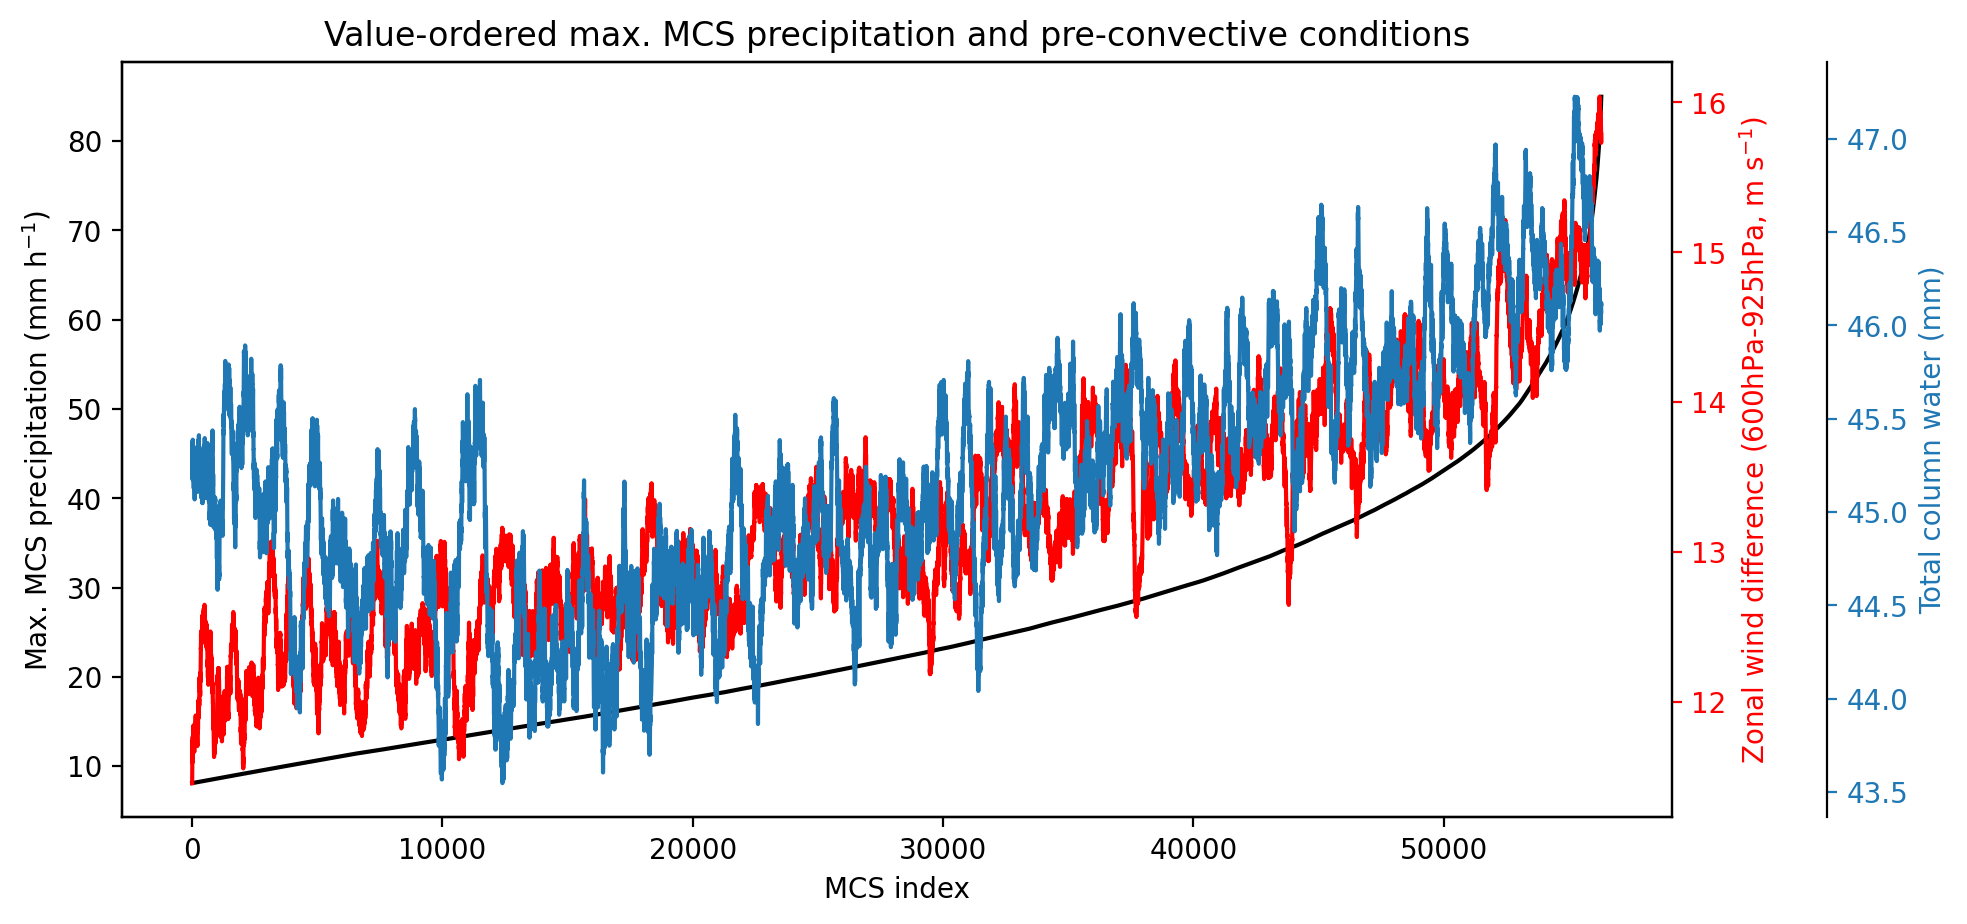

In [297]:
obsord = obs[np.isfinite(obs['prcp']) & np.isfinite(obs['shear']) & np.isfinite(obs['q925']) & np.isfinite(obs['t925'])]
inds = np.argsort(obsord['prcp'])

minus = -20000
pro = obsord['prcp'].values[inds]#[minus::]
sho = obsord['shear'].values[inds]#[minus::]
tco = obsord['tcwv'].values[inds]#[minus::]
qco = obsord['q925'].values[inds]#[minus::]
temp = obsord['t925'].values[inds]#[minus::]
qupco = obsord['q650'].values[inds]#[minus::]

f = plt.figure(figsize=(10,5), dpi=200)
ax = f.add_subplot(111)
ax2 = ax.twinx()
#ax3 = ax.twinx()
ax4 = ax.twinx()

agg = 400


# Offset the right spine of twin2.  The ticks and label have already been
# placed on the right by twinx above.
#ax2.spines["right"].set_position(("axes", 1.02))
#ax3.spines["right"].set_position(("axes", 1.1))
ax4.spines["right"].set_position(("axes", 1.1))

ax.plot(moving_average(pro,agg), label='prcp', color='k')

p4, = ax4.plot(moving_average(tco,agg), label='tcwv')
p2, = ax2.plot(moving_average(sho,agg), label='shear', color='r')
#p3, = ax3.plot(moving_average(qco,500), label='q925', color='purple')
#p4, = ax4.plot(moving_average(temp,500), label='t925', color='orange')

ax2.yaxis.label.set_color(p2.get_color())
#ax3.yaxis.label.set_color(p3.get_color())
ax4.yaxis.label.set_color(p4.get_color())

tw = moving_average(tco,agg)
twd = tw[1::]-tw[0:-1]
sw = moving_average(sho,agg)
swd = sw[1::]-sw[0:-1]

print(stats.pearsonr(twd,swd))

ax.set_ylabel('Max. MCS precipitation (mm h$^{-1}$)')
ax2.set_ylabel('Zonal wind difference (600hPa-925hPa, m s$^{-1}$)')
ax4.set_ylabel('Total column water (mm)')


ax2.tick_params(axis='y', colors=p2.get_color())
#ax3.tick_params(axis='y', colors=p3.get_color() )
ax4.tick_params(axis='y', colors=p4.get_color())

ax.set_title('Value-ordered max. MCS precipitation and pre-convective conditions')
ax.set_xlabel('MCS index')

#f.savefig('/home/ck/DIR/cornkle/figs/ENDGAME/ordered_MCSs/maxP_ordered_15000.jpg')

(-0.10472260033756692, 0.3125060471551889)


Text(0.5, 0, 'MCS index')

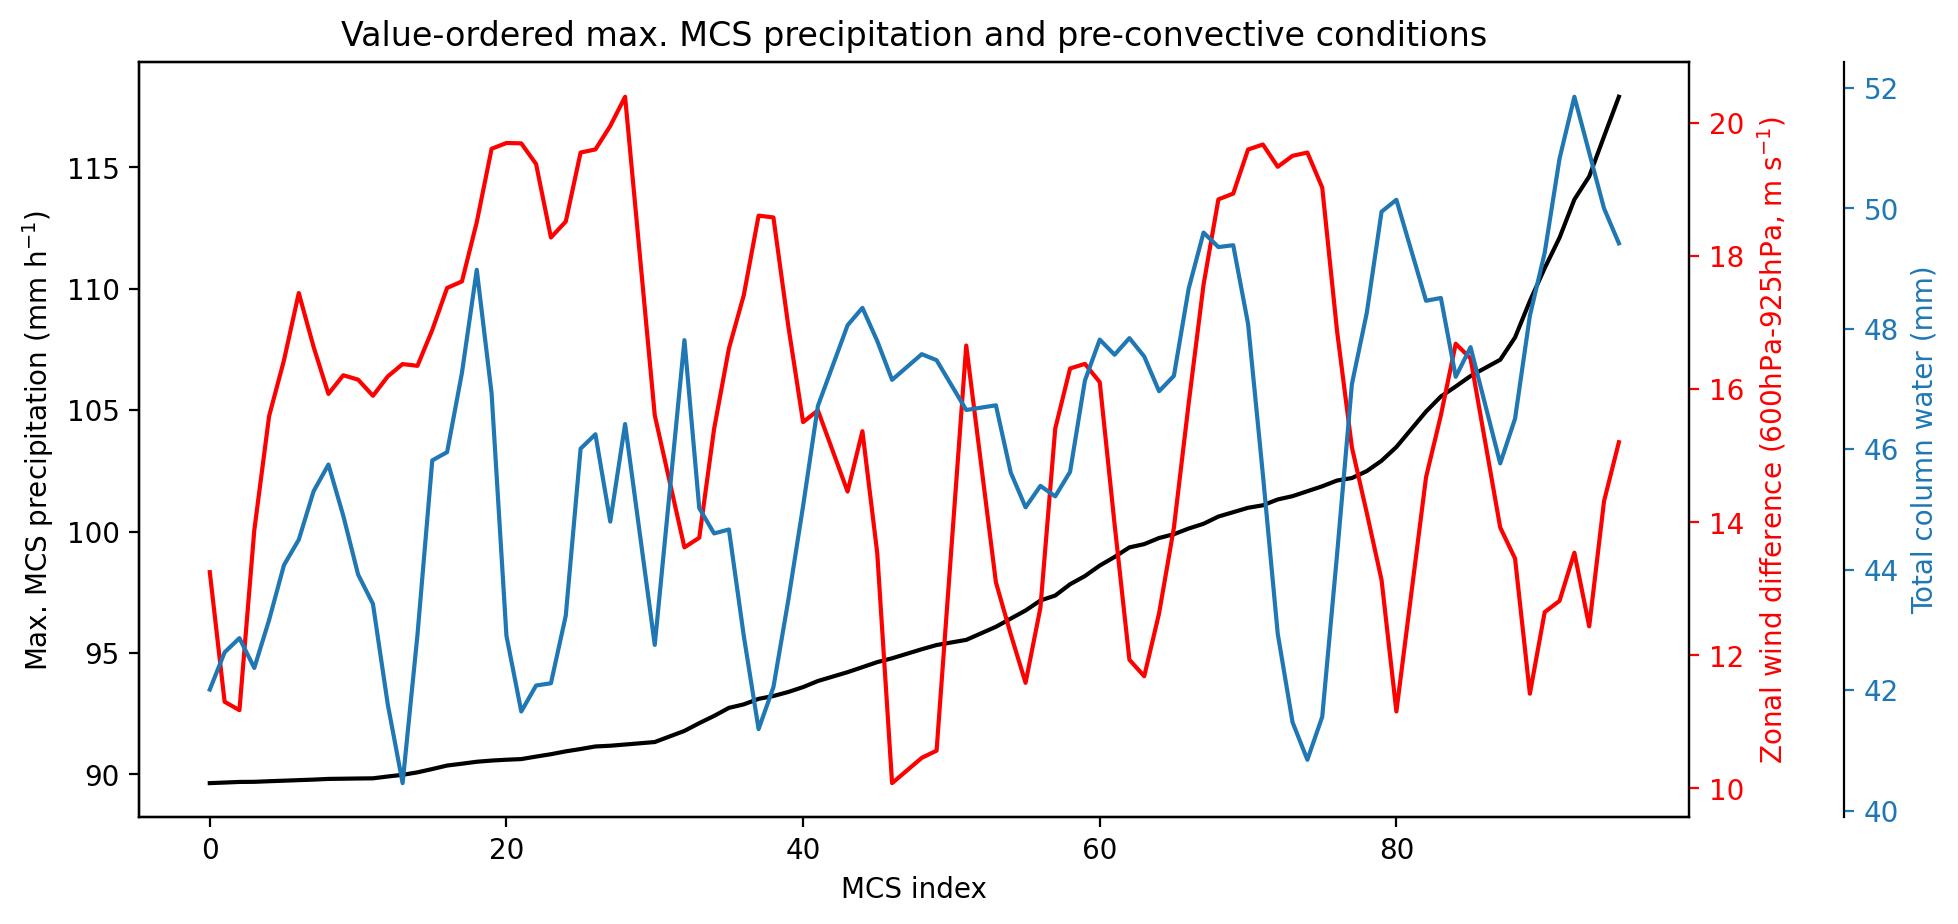

In [298]:
obsord = obs[np.isfinite(obs['prcp']) & np.isfinite(obs['shear']) & np.isfinite(obs['q925']) & np.isfinite(obs['t925'])]
inds = np.argsort(obsord['prcp'])

minus = -100
pro = obsord['prcp'].values[inds][minus::]
sho = obsord['shear'].values[inds][minus::]
tco = obsord['tcwv'].values[inds][minus::]
qco = obsord['q925'].values[inds][minus::]
temp = obsord['t925'].values[inds][minus::]
qupco = obsord['q650'].values[inds][minus::]

f = plt.figure(figsize=(10,5), dpi=200)
ax = f.add_subplot(111)
ax2 = ax.twinx()
#ax3 = ax.twinx()
ax4 = ax.twinx()

agg = 5


# Offset the right spine of twin2.  The ticks and label have already been
# placed on the right by twinx above.
#ax2.spines["right"].set_position(("axes", 1.02))
#ax3.spines["right"].set_position(("axes", 1.1))
ax4.spines["right"].set_position(("axes", 1.1))

ax.plot(moving_average(pro,agg), label='prcp', color='k')

p4, = ax4.plot(moving_average(tco,agg), label='tcw')
p2, = ax2.plot(moving_average(sho,agg), label='shear', color='r')
#p3, = ax3.plot(moving_average(qco,500), label='q925', color='purple')
#p4, = ax4.plot(moving_average(temp,500), label='t925', color='orange')

ax2.yaxis.label.set_color(p2.get_color())
#ax3.yaxis.label.set_color(p3.get_color())
ax4.yaxis.label.set_color(p4.get_color())

tw = moving_average(tco,agg)
twd = tw[1::]-tw[0:-1]
sw = moving_average(sho,agg)
swd = sw[1::]-sw[0:-1]

print(stats.pearsonr(twd,swd))

ax.set_ylabel('Max. MCS precipitation (mm h$^{-1}$)')
ax2.set_ylabel('Zonal wind difference (600hPa-925hPa, m s$^{-1}$)')
ax4.set_ylabel('Total column water (mm)')


ax2.tick_params(axis='y', colors=p2.get_color())
#ax3.tick_params(axis='y', colors=p3.get_color() )
ax4.tick_params(axis='y', colors=p4.get_color())

ax.set_title('Value-ordered max. MCS precipitation and pre-convective conditions')
ax.set_xlabel('MCS index')

#f.savefig('/home/ck/DIR/cornkle/figs/ENDGAME/ordered_MCSs/maxP_ordered.jpg')

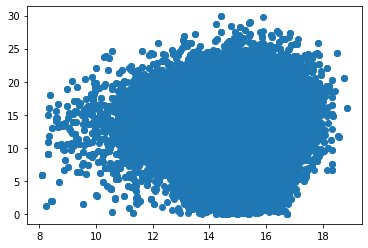

In [299]:
plt.scatter(obs.q925, obs.shear)

In [300]:
def gauss(data, sigma):
    sigma=sigma                  # standard deviation for Gaussian kernel
    truncate=4.0               # truncate filter at this many sigmas

    U=data       # random array...

    V=U.copy()
    V[np.isnan(U)]=0
    VV=ndimage.gaussian_filter(V,sigma=sigma,truncate=truncate)

    W=0*U.copy()+1
    W[np.isnan(U)]=0
    WW=ndimage.gaussian_filter(W,sigma=sigma,truncate=truncate)

    Z=VV/WW
    return Z

In [301]:
#obs = obs[obs['shear']>15]

In [302]:
# sbin = np.linspace(0,26.8,25)
# tbin = np.linspace(27,57,25)

sbin = np.linspace(5000,100000,28) #28

tbin = np.linspace(0,26.7,28) #28
#tbin = np.linspace(27,57,28)

q1 = 0.8 #0.8
q2 = 99.5#99.5
#sbin = np.linspace(np.percentile(obs.area,q1) ,np.max([np.percentile(obs.area,q2),np.percentile(cp4.area,q2)]),26) #np.min([np.percentile(obs.shear,q1),np.percentile(cp4.shear,q1)])
#tbin = np.linspace(np.min([np.percentile(obs.tcwv,q1),np.percentile(cp4.tcwv,q1)]) ,np.max([np.percentile(obs.tcwv,q2),np.percentile(cp4.tcwv,q2)]),26)

testbins = [sbin,tbin]
func1 = lambda y: np.percentile(y,95, interpolation='nearest') #np.percentile(y, 95)
func2 = lambda y: np.sum(np.isfinite(y))
func3 = lambda y: np.sum(y>40)
ret = binned_statistic_2d(obs2['area'], obs2['shear'], obs2['prcp'], statistic=func1, bins=testbins)
count = binned_statistic_2d(obs2['area'], obs2['shear'], obs2['prcp'], statistic=func2, bins=testbins)
thresh = binned_statistic_2d(obs2['area'], obs2['shear'], obs2['prcp'], statistic=func3, bins=testbins)

In [303]:
# # sbin = np.linspace(0,26.8,25)
# # tbin = np.linspace(27,57,25)

# sbin = np.linspace(0,26.7,28) #28
# #tbin = np.linspace(27,57,28)

# q1 = 0.2 #0.8
# q2 = 99.8#99.5
# sbin = np.linspace(np.percentile(obs.shear,q1) ,np.max([np.percentile(obs.shear,q2),np.percentile(cp4.shear,q2)]),28) #np.min([np.percentile(obs.shear,q1),np.percentile(cp4.shear,q1)])
# tbin = np.linspace(np.min([np.percentile(obs.tcwv,q1),np.percentile(cp4.tcwv,q1)]) ,np.max([np.percentile(obs.tcwv,q2),np.percentile(cp4.tcwv,q2)]),28)

# testbins = [sbin,tbin]
# func1 = lambda y: np.percentile(y, 95)
# func2 = lambda y: np.sum(np.isfinite(y))
# ret = binned_statistic_2d(obs['shear'], obs['tcwv'], obs['prcp'], statistic=func1, bins=testbins)
# count = binned_statistic_2d(obs['shear'], obs['tcwv'], obs['prcp'], statistic=func2, bins=testbins)

In [304]:
ret4 = binned_statistic_2d(cp4['area'], cp4['shear'], cp4['prcp'], statistic=func1, bins=testbins)
count4 = binned_statistic_2d(cp4['area'], cp4['shear'], cp4['prcp'], statistic=func2, bins=testbins)

In [305]:
def run_small(data, count, testbins, axis=0):
    
    dd = gauss(data.statistic.T, 0.6)
    invalid = count.statistic.T < 10
    dd[invalid] = np.nan
    
    mean = np.nanmean(dd,axis=axis)
    val = np.nansum(np.isfinite(dd),axis=axis)
    
    mean[val<4] = np.nan
    
    perc = np.nanpercentile(dd, [10,90], axis=axis)
    
    def weighted_regress(bins,data, pval):
        import statsmodels.api as sm
        data = np.array(data)
        pos = np.isfinite(data)
        inbins = bins#[pos]
        indata = data#[pos]
        inval = np.array(pval)#[pos]
        X = sm.add_constant(inbins)
        weight = inval / np.sum(inval)
        #ipdb.set_trace()
        return sm.WLS(indata,X, missing='drop', weights=weight).fit() # #, weights=weight
    
    sbin = testbins[axis]
    bins = np.round(sbin[0:-1]+((sbin[1::]-sbin[0:-1])/2),2)
    fillmean = mean.copy()
    fillmean[np.isnan(fillmean)]=0

    val[np.isnan(fillmean)]=0
    wls_model = weighted_regress(bins[0:-3], fillmean[0:-3], val[0:-3])

    intercept = wls_model.params[0] #  intercept
    slope = wls_model.params[1] #  slope
    r_value = wls_model.rsquared  #rsquared
    
    #ipdb.set_trace()
    
    print(wls_model.summary())
    
    
   # ipdb.set_trace()
    
    odic = {
        'slope' : slope,
        'intercept' : intercept,
        'rval' : r_value,
        'pmean' :mean,
        'p90' : perc[0],
        'p10' : perc[1],
        'bins' : bins,
        'std_est' : wls_model.bse[0],
        'valid' : val,
        'model' : wls_model
    }
    
    return odic

In [306]:
def run_small_2d(data, count, testbins):
    
    dd = gauss(data.statistic.T, 0.4)
    invalid = count.statistic.T < 10
    dd[invalid] = np.nan
    
    
    mean_x = np.nanmean(dd,axis=0)
    val_x = np.nansum(np.isfinite(dd),axis=0)
    mean_x[val_x<4] = np.nan
    perc_x = np.nanpercentile(dd, [10,90], axis=0)
    
    mean_y = np.nanmean(dd,axis=1)
    val_y = np.nansum(np.isfinite(dd),axis=1)
    mean_y[val_y<4] = np.nan
    perc_y = np.nanpercentile(dd, [10,90], axis=1)
    
    
    sbin = testbins[0]
    tbin = testbins[1]
    ssbins = np.round(sbin[0:-1]+((sbin[1::]-sbin[0:-1])/2),2)
    ttbins = np.round(tbin[0:-1]+((tbin[1::]-tbin[0:-1])/2),2)
    
    X,Y = np.meshgrid(ssbins, ttbins)

    # First we need to flatten the data: it's 2D layout is not relevent.
    counts = count.statistic.T
    Z = dd.flatten()
    X = X.flatten()
    Y = Y.flatten()
    inval = counts.flatten()
    
   
    ################################################################
    # For 3d plots. This import is necessary to have 3D plotting below
    from mpl_toolkits.mplot3d import Axes3D
    import pandas
    # For statistics. Requires statsmodels 5.0 or more
    from statsmodels.formula.api import wls
    # Analysis of Variance (ANOVA) on linear models
    from statsmodels.stats.anova import anova_lm
    # Convert the data into a Pandas DataFrame to use the formulas framework
    # in statsmodels


    data = pandas.DataFrame({'x': X, 'y': Y, 'z': Z})
    weight = inval / np.sum(inval)
    # Fit the model
    model = wls("z ~ x + y", data, weights=weight, missing='drop').fit()

    # Print the summary
    print(model.summary())

    print("\nRetrieving manually the parameter estimates:")
    print(model._results.params)
    # should be array([-4.99754526,  3.00250049, -0.50514907])

    # Peform analysis of variance on fitted linear model
    anova_results = anova_lm(model)

    print('\nANOVA results')
    print(anova_results)

    plt.show()
    ################################################################
    
    odic = {
        'model' : model,
        'pmean_x' :mean_x,
        'pmean_y' :mean_y,
        'p90_x' : perc_x[0],
        'p10_x' : perc_x[1],
        'p90_y' : perc_y[0],
        'p10_y' : perc_y[1],
        'bins_x' : ssbins,
        'bins_y' : ttbins
    }
    
    return odic

In [261]:
tdicobs = run_small(ret, count, testbins,axis=1)
sdicobs = run_small(ret, count, testbins,axis=0)
tdic4 = run_small(ret4, count4, testbins,axis=1)
sdic4 = run_small(ret4, count4, testbins,axis=0)

                            WLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.286
Model:                            WLS   Adj. R-squared:                  0.253
Method:                 Least Squares   F-statistic:                     8.806
Date:                Thu, 29 Sep 2022   Prob (F-statistic):            0.00711
Time:                        18:42:25   Log-Likelihood:                -75.207
No. Observations:                  24   AIC:                             154.4
Df Residuals:                      22   BIC:                             156.8
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const         42.2621      2.728     15.490      0.0

/home/ck/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:7: RuntimeWarning: Mean of empty slice
  import sys
/home/ck/miniconda3/lib/python3.7/site-packages/numpy/lib/nanfunctions.py:1390: RuntimeWarning: All-NaN slice encountered
  overwrite_input, interpolation)
/home/ck/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:15: RuntimeWarning: invalid value encountered in true_divide
  from ipykernel import kernelapp as app
/home/ck/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:15: RuntimeWarning: invalid value encountered in true_divide
  from ipykernel import kernelapp as app


In [262]:
def binning_hist(bins, shape):
    scat = np.repeat(bins,shape[1],axis=0).reshape(shape)
    return scat

In [263]:
tdicobs.r_value

AttributeError: 'dict' object has no attribute 'r_value'

In [264]:
tb = testbins[1][0:-1] + (testbins[1][1::] - testbins[1][0:-1])/2
sb = testbins[0][0:-1] + (testbins[0][1::] - testbins[0][0:-1])/2

In [265]:
len(tb)

27

In [266]:
wgrid = binning_hist(tb,ret.statistic.T.shape)
sgrid = binning_hist(sb,ret.statistic.shape)

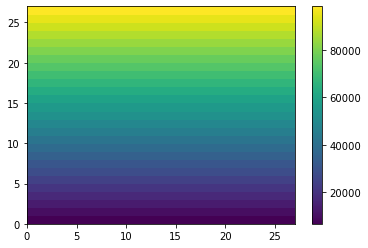

In [267]:
plt.pcolormesh(sgrid)
plt.colorbar()

In [268]:
wgrid[0,:]

array([0.49444444, 0.49444444, 0.49444444, 0.49444444, 0.49444444,
       0.49444444, 0.49444444, 0.49444444, 0.49444444, 0.49444444,
       0.49444444, 0.49444444, 0.49444444, 0.49444444, 0.49444444,
       0.49444444, 0.49444444, 0.49444444, 0.49444444, 0.49444444,
       0.49444444, 0.49444444, 0.49444444, 0.49444444, 0.49444444,
       0.49444444, 0.49444444])

In [269]:
np.nanmean(ret.statistic.T, axis=0).shape

(27,)

In [270]:
def find_cumsum(x, thresh):
    pos = np.where(np.cumsum(np.sort(x)[::-1])>=thresh)
    val = (np.sort(x)[::-1])[pos[0][0]]
    #ipdb.set_trace()
    return np.where(x>=val)[0]

In [271]:
frac4_tcw = np.sum(count4.statistic.T,axis=1)/np.sum(count4.statistic)
frac4_shear = np.sum(count4.statistic.T,axis=0)/np.sum(count4.statistic)

frac_tcw = np.sum(count.statistic.T,axis=1)/np.sum(count.statistic)
frac_shear = np.sum(count.statistic.T,axis=0)/np.sum(count.statistic)

In [272]:
def density_plot(v1,v2):
    xy = np.vstack([v1, v2])
    z = gaussian_kde(xy)(xy)
    data = z / (z.max() - z.min())

#     rr = stats.pearsonr(v1,v2)
#     print('pears', stats.pearsonr(v1,v2))
    
    return data

In [273]:
mask = np.isfinite(wgrid) & np.isfinite(ret.statistic.T)
dens = density_plot(wgrid[mask],ret.statistic.T[mask])

In [274]:
def weighted_regress(bins,data, pval):
    import statsmodels.api as sm
    data = np.array(data)
    pos = np.isfinite(data)
    inbins = bins#[pos]
    indata = data#[pos]
    inval = np.array(pval)#[pos]
    X = sm.add_constant(inbins)
    weight = inval / np.sum(inval)
    #ipdb.set_trace()
    return sm.WLS(indata,X, missing='drop', weights=weight).fit() # #, weights=weight

In [275]:
mask = np.isfinite(wgrid.flat) & np.isfinite(ret.statistic.T.flat) & (count.statistic.T.flat>10)
wls_model = weighted_regress(wgrid.flat[mask], ret.statistic.T.flat[mask], count.statistic.T.flat[mask])

In [276]:
wls_model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            WLS Regression Results                            
==============================================================================
Dep. Variable:                      y   R-squared:                       0.145
Model:                            WLS   Adj. R-squared:                  0.143
Method:                 Least Squares   F-statistic:                     68.66
Date:                Thu, 29 Sep 2022   Prob (F-statistic):           1.73e-15
Time:                        18:42:40   Log-Likelihood:                -1545.2
No. Observations:                 407   AIC:                             3094.
Df Residuals:                     405   BIC:                             3102.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const         37.7030      1.141     33.046      0.000      35.460      39.946
x1             0.7476      0.090      8.286      0.000       0.570       0.925
==============================================================================
Omnibus:                       32.489   Durbin-Watson:                   1.522
Prob(Omnibus):                  0.000   Jarque-Bera (JB):               61.830
Skew:                           0.477   Prob(JB):                     3.75e-14
Kurtosis:                       4.654   Cond. No.                         33.8
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

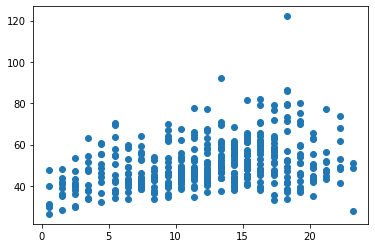

In [277]:
plt.scatter(wgrid.flat[mask],ret.statistic.T.flat[mask])

In [278]:
from utils import u_statistics as ustats

In [279]:
dicobs = run_small_2d(ret, count, testbins)
dic4 = run_small_2d(ret4, count4, testbins)

                            WLS Regression Results                            
Dep. Variable:                      z   R-squared:                       0.373
Model:                            WLS   Adj. R-squared:                  0.370
Method:                 Least Squares   F-statistic:                     126.2
Date:                Thu, 29 Sep 2022   Prob (F-statistic):           9.33e-44
Time:                        18:42:43   Log-Likelihood:                -1522.5
No. Observations:                 428   AIC:                             3051.
Df Residuals:                     425   BIC:                             3063.
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept     35.0576      0.894     39.224      0.0

/home/ck/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:13: RuntimeWarning: Mean of empty slice
  del sys.path[0]
/home/ck/miniconda3/lib/python3.7/site-packages/numpy/lib/nanfunctions.py:1390: RuntimeWarning: All-NaN slice encountered
  overwrite_input, interpolation)
/home/ck/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:15: RuntimeWarning: invalid value encountered in true_divide
  from ipykernel import kernelapp as app


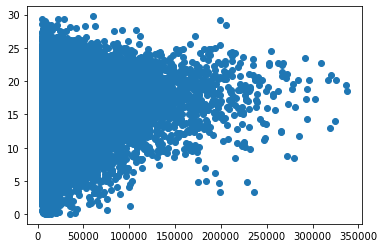

In [280]:
plt.scatter(cp4['area'], cp4['shear'])

In [281]:
def func(x,y):
    return 2.3075 + 0.9421*x + 0.7397* y

In [282]:
tests = np.zeros((26,26))
for yid, y in enumerate(np.linspace(25,57,26)):
    for xid, x in enumerate(np.linspace(0,28,26)):
        tests[yid,xid] = func(x,y)

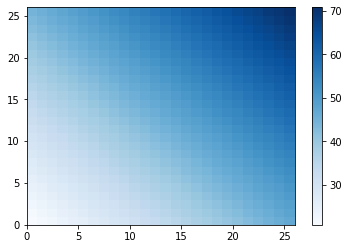

In [283]:
plt.pcolormesh(tests, cmap='Blues')
plt.colorbar()

In [284]:
ret4.statistic.T

array([[42.66064648, 49.20579768, 41.16322556, 53.49160892, 41.07906425,
        36.70753593,         nan,         nan, 48.05930401,         nan,
        34.23835294,         nan,         nan,         nan,         nan,
                nan,         nan,         nan,         nan,         nan,
        31.04854503,         nan,         nan,         nan,         nan,
                nan,         nan],
       [40.43504574, 44.29974573, 31.27944339, 29.13494731, 63.54224266,
        37.14219999, 20.56134728, 44.12943546, 44.42263376, 44.14142602,
                nan,         nan,         nan,         nan, 45.76239956,
        18.28467597, 49.76148725, 24.28246796,         nan,         nan,
                nan,         nan,         nan,         nan,         nan,
                nan,         nan],
       [40.82605012, 52.09248317, 41.19441736, 39.7421609 , 40.67730043,
        48.0581239 , 29.24953979, 44.00691258, 49.68292189,         nan,
                nan, 32.10357689,         nan,        

bigpos (array([11, 11, 12, 12, 12, 12, 12, 13, 13, 15, 16, 16, 17, 17, 17, 17, 17,
       18, 18, 18, 18, 18, 18, 18, 19]), array([18, 19, 18, 19, 20, 21, 22, 21, 22, 17, 17, 22,  8, 16, 20, 21, 22,
        8, 16, 20, 21, 22, 23, 25, 24]))


Text(0.5, 1.0, 'CP4 model: Maximum MCS rainfall')

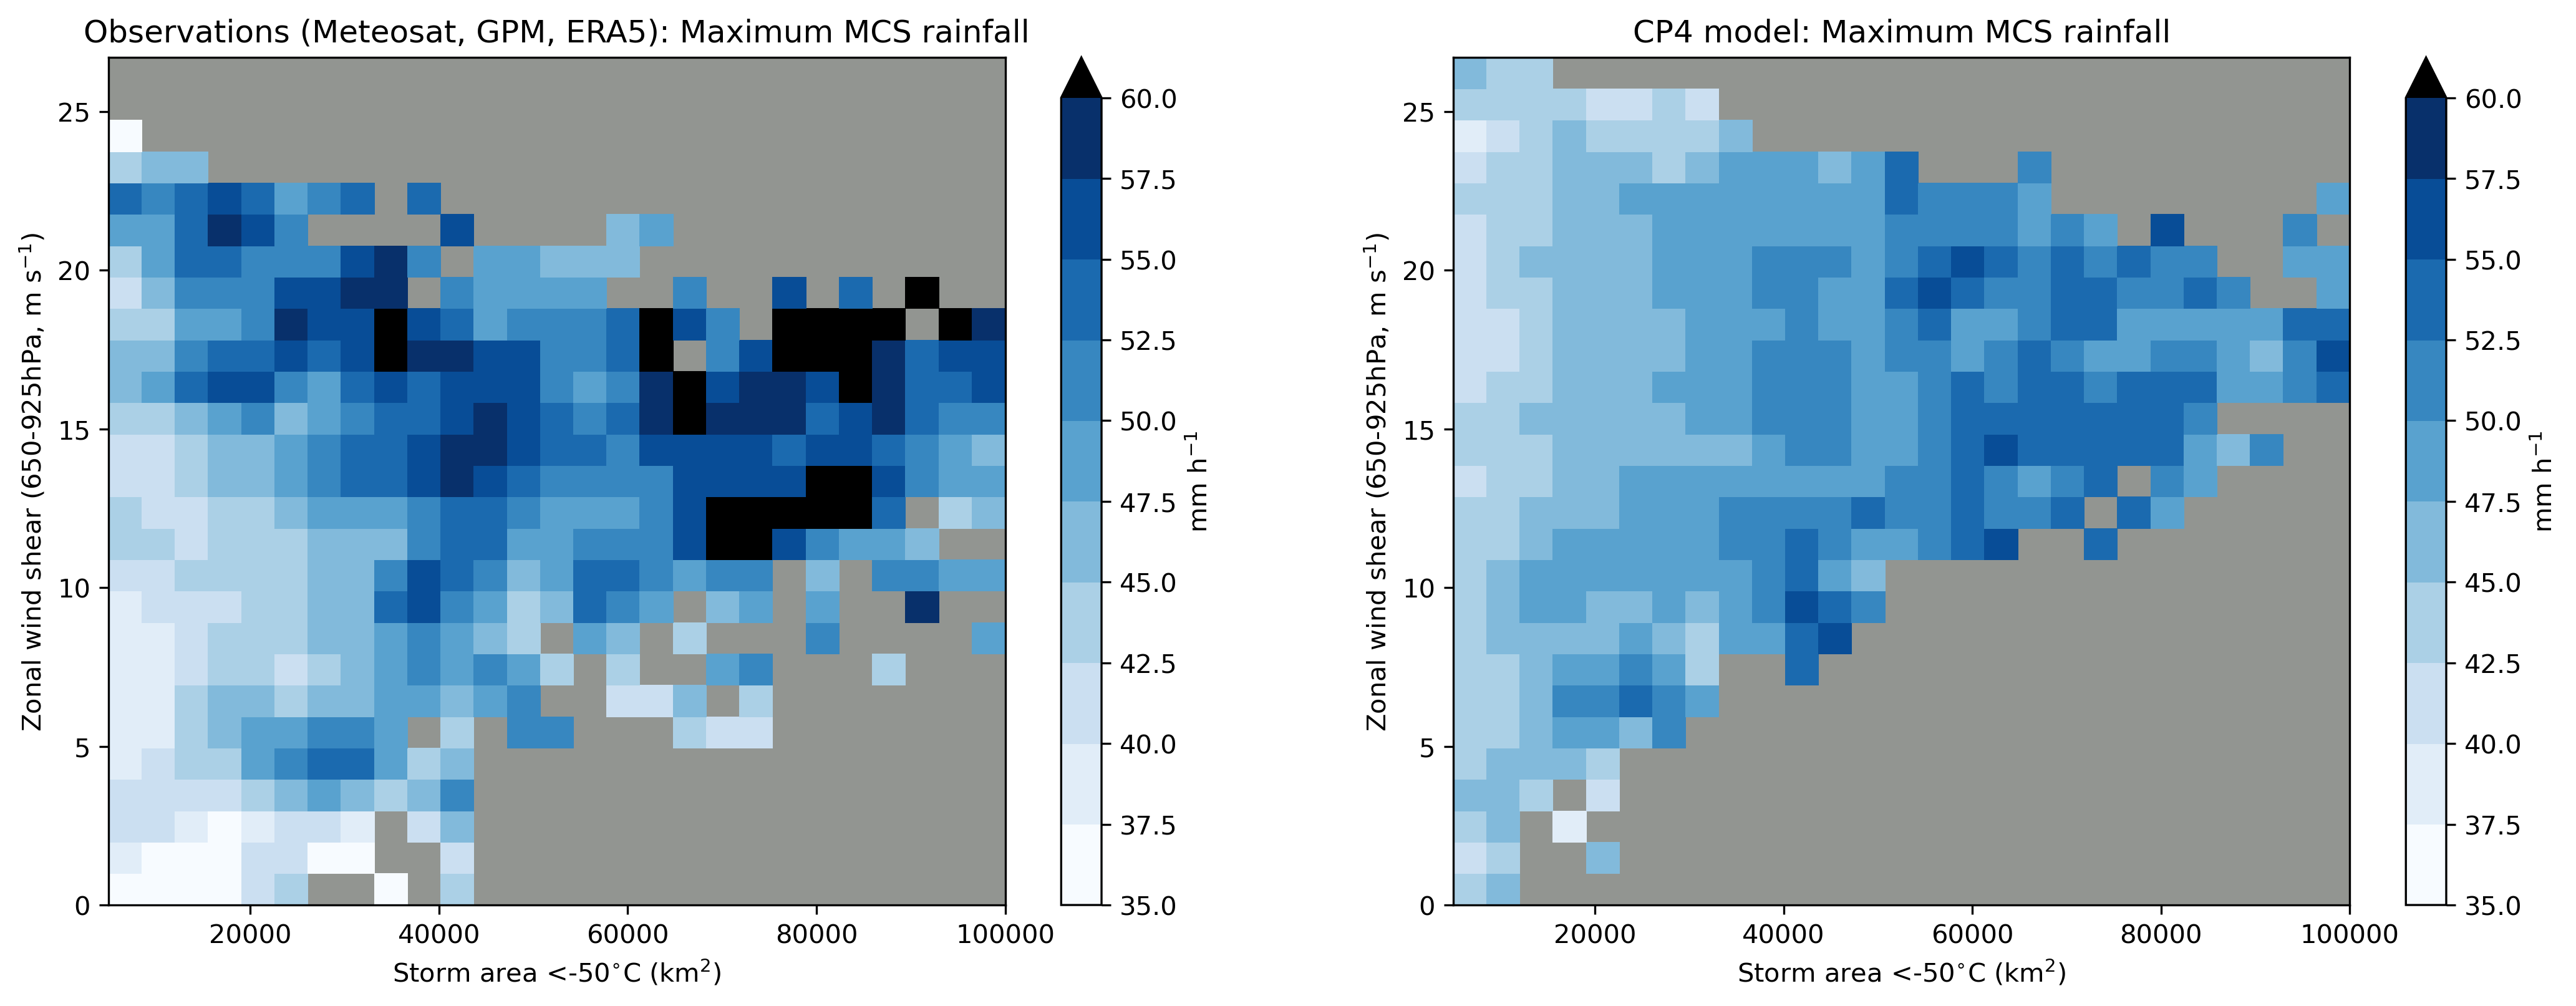

In [285]:
f = plt.figure(figsize=(17,6), dpi=300)
cmap='Blues'
vmins = 35
vmaxs = 60
pixelval = 10
cmapp = uplot.discrete_cmap(10, base_cmap=cmap)
ax = f.add_subplot(1,2,1)
ax.set_facecolor('xkcd:grey')
dd = gauss(ret.statistic.T, 0.8)
invalid = count.statistic.T < pixelval
dd[invalid] = np.nan
bigpos = np.where(dd>60)
print('bigpos', bigpos)
mp = plt.pcolormesh(testbins[0], testbins[1], dd, cmap=cmapp, vmin=vmins, vmax=vmaxs)
#plt.plot(testbins[0][bigpos[1]+1],testbins[1][bigpos[0]+1], 'o', color='grey', ms=1)

plt.xlabel('Storm area <-50$^{\circ}$C (km$^2$)')
plt.ylabel('Zonal wind shear (650-925hPa, m s$^{-1}$)')
#plt.text(1,56, r'r$^2$ = '+str(np.round(dicobs['model'].rsquared,2)), fontsize=10)
plt.title('Observations (Meteosat, GPM, ERA5): Maximum MCS rainfall')

cbar = plt.colorbar(mp, ticks=np.linspace(vmins, vmaxs,11), extend='max')
cbar.set_label('mm h$^{-1}$')

ax = f.add_subplot(1,2,2)
ax.set_facecolor('xkcd:grey')
dd = gauss(ret4.statistic.T, 0.7)
invalid = count4.statistic.T < pixelval
dd[invalid] = np.nan
cmapp.set_over("black")
mp = plt.pcolormesh(testbins[0], testbins[1], dd, cmap=cmapp, vmin=vmins, vmax=vmaxs)
cbar = plt.colorbar(mp, ticks=np.linspace(vmins,vmaxs,11), extend='max')
cbar.set_label('mm h$^{-1}$')

plt.xlabel('Storm area <-50$^{\circ}$C (km$^2$)')
plt.ylabel('Zonal wind shear (650-925hPa, m s$^{-1}$)')

plt.title('CP4 model: Maximum MCS rainfall')

# ax2 = f.add_subplot(223)



# plt.plot(tdicobs['bins'],tdicobs['pmean'], '-ko', label=r'OBS | $\dfrac{\partial P_{max^{95}}}{\partial TCW}$: ' + str(np.round(tdicobs['slope'],2))+r'$\pm$'+str(np.round(tdicobs['model'].bse[1],2)))
# plt.fill_between(tdicobs['bins'],tdicobs['p10'],tdicobs['p90'], color='k', alpha=0.15)
# plt.fill_between(tdic4['bins'],tdic4['p10'],tdic4['p90'], color='xkcd:blue', alpha=0.15)
# plt.plot(tdic4['bins'],tdic4['pmean'], color='xkcd:blue', marker='o', label='CP4$_H$ | $\dfrac{\partial P_{max^{95}}}{\partial TCW}$: ' + str(np.round(tdic4['slope'],2))+'$\pm$'+str(np.round(tdic4['model'].bse[1],2)))

# indx = find_cumsum(frac_tcw, 0.8)
# plt.plot(tdicobs['bins'][indx-2],tdicobs['pmean'][indx-2],marker='o', color='white', markersize=2, linestyle='')
# indx = find_cumsum(frac4_tcw, 0.8)
# plt.plot(tdic4['bins'][indx],tdic4['pmean'][indx],marker='o', color='white', markersize=2, linestyle='')

# #plt.plot(tdicobs['bins'],tdicobs['slope']*tdicobs['bins']+tdicobs['intercept'], linestyle='dashed', color='k', linewidth=0.5)
# plt.plot(tdicobs['bins'],tdicobs['slope']*tdicobs['bins']+tdicobs['intercept'], linestyle='dashed', color='k', linewidth=0.5)
# # plt.plot(tdicobs['bins'],(tdicobs['slope']-np.array(dicobs['model'].bse[2]))*tdicobs['bins']+tdicobs['intercept']-dicobs['model'].bse[0], linestyle='dashed', color='k', linewidth=0.5, alpha=0.15)
# # plt.plot(tdicobs['bins'],(tdicobs['slope']+np.array(dicobs['model'].bse[2]))*tdicobs['bins']+tdicobs['intercept']+dicobs['model'].bse[0], linestyle='dashed', color='k', linewidth=0.5, alpha=0.15)

# plt.fill_between(tdic4['bins'],tdic4['p10'],tdic4['p90'], color='xkcd:blue', alpha=0.15)


# plt.plot(tdic4['bins'],tdic4['slope']*tdic4['bins']+tdic4['intercept'], linestyle='dashed', color='k', linewidth=0.5)

# # plt.plot(tdicobs['bins'],tdicobs['slope']*tdicobs['bins']+tdicobs['intercept']+tdicobs['std_est']*2, linestyle='dotted', color='grey', linewidth=0.5)
# # plt.plot(tdicobs['bins'],tdicobs['slope']*tdicobs['bins']+tdicobs['intercept']-tdicobs['std_est']*2, linestyle='dotted', color='grey', linewidth=0.5)

# # plt.plot(tdic4['bins'],tdic4['slope']*tdic4['bins']+tdic4['intercept']+tdic4['std_est']*2, linestyle='dashed', color='k', linewidth=0.5)
# # plt.plot(tdic4['bins'],tdic4['slope']*tdic4['bins']+tdic4['intercept']-tdic4['std_est']*2, linestyle='dashed', color='k', linewidth=0.5)
# plt.xlabel('TCW (mm)')
# plt.ylabel('$P_{max^{95}}$ (mm h$^{-1}$)')


# #plt.title('Zonal wind shear')
# #plt.ylim(12,31)
# #plt.ylim(15,33)
# plt.ylim(25,70)
# ax2.xaxis.set_minor_locator(MultipleLocator(5))
# ax2.yaxis.set_minor_locator(MultipleLocator(5))
# plt.legend(loc='upper left')
# # plt.text(50,28, r'SE$_{OBS} = $'+str(np.round(tdicobs['std_est'],2)), fontsize=10)
# # plt.text(50,26, r'SE$_{CP4_H} = $'+str(np.round(tdic4['std_est'],2)), fontsize=10)




# ax3 = f.add_subplot(224)
# plt.plot(sdicobs['bins'],sdicobs['pmean'], '-ko', label=r'OBS | $\dfrac{\partial \overline{P_{max^{95}}}}{\partial shear}$: ' + str(np.round(sdicobs['slope'],2))+'$\pm$'+str(np.round(sdicobs['model'].bse[1],2)))
# plt.fill_between(sdicobs['bins'],sdicobs['p10'],sdicobs['p90'], color='k', alpha=0.15)
# plt.fill_between(sdic4['bins'],sdic4['p10'],sdic4['p90'], color='xkcd:blue', alpha=0.15)

# plt.plot(sdic4['bins'],sdic4['pmean'], color='xkcd:blue', marker='o', label=r'CP4$_{H}$ | $\dfrac{\partial \overline{P_{max^{95}}}}{\partial shear}$: ' + str(np.round(sdic4['slope'],2))+'$\pm$'+str(np.round(sdic4['model'].bse[1],2)))
# #plt.plot(sdicobs['bins'],sdicobs['slope']*sdicobs['bins']+sdicobs['intercept'], linestyle='dashed', color='k', linewidth=0.5)
# plt.plot(sdicobs['bins'],sdicobs['slope']*sdicobs['bins']+sdicobs['intercept'], linestyle='dashed', color='k', linewidth=0.5)


# plt.plot(sdic4['bins'],sdic4['slope']*sdic4['bins']+sdic4['intercept'], linestyle='dashed', color='k', linewidth=0.5)

# indx = find_cumsum(frac_shear, 0.8)
# plt.plot(sdicobs['bins'][indx-2],sdicobs['pmean'][indx-2],marker='o', color='white', markersize=2, linestyle='')
# indx = find_cumsum(frac4_shear, 0.8)
# plt.plot(sdic4['bins'][indx],sdic4['pmean'][indx],marker='o', color='white', markersize=2, linestyle='')

# fdic = {'obs_shear' : sdicobs['slope'], 'cp4_shear' : sdic4['slope'], 'SE' : sdicobs['model'].bse[1]}
# import pickle
# pickle.dump(fdic, open('/home/ck/DIR/cornkle/figs/ENDGAME/shear_factors_small.p', "wb"))

# #plt.xlabel('Specific humidity (925hPa, g kg$^{-1}$)')

# plt.xlabel('Zonal wind shear (650-925hPa, m s$^{-1}$)')
# plt.ylabel('$P_{max^{95}}$ (mm h$^{-1}$)')
# #plt.title('Total column water vapour')
# plt.legend(loc='upper left')
# # plt.text(21,28, r'SE$_{OBS} = $'+str(np.round(dicobs['model'].bse[1],2)), fontsize=10)
# # plt.text(21,26, r'SE$_{CP4_H} = $'+str(np.round(dic4['model'].bse[1],2)), fontsize=10)
# # plt.text(21,28, r'SE$_{OBS} = $'+str(np.round(dicobs['model'].bse[0],2)), fontsize=10)
# # plt.text(21,26, r'SE$_{CP4_H} = $'+str(np.round(sdic4['std_est'],2)), fontsize=10)
# plt.tight_layout()
# plt.ylim(25,70)
# ax3.xaxis.set_minor_locator(MultipleLocator(5))
# ax3.yaxis.set_minor_locator(MultipleLocator(5))


# text = ['a', 'b', 'c', 'd']
# plt.annotate(text[0], xy=(0.01, 0.96), xytext=(0, 4), xycoords=('figure fraction', 'figure fraction'),
#              textcoords='offset points', fontweight='bold', fontname='Ubuntu', fontsize=16)
# plt.annotate(text[1], xy=(0.53, 0.96), xytext=(0, 4), xycoords=('figure fraction', 'figure fraction'),
#              textcoords='offset points', fontweight='bold', fontname='Ubuntu', fontsize=16)
# plt.annotate(text[2], xy=(0.01, 0.49), xytext=(0, 4), xycoords=('figure fraction', 'figure fraction'),
#              textcoords='offset points', fontweight='bold', fontname='Ubuntu', fontsize=16)
# plt.annotate(text[3], xy=(0.53, 0.49), xytext=(0, 4), xycoords=('figure fraction', 'figure fraction'),
#              textcoords='offset points', fontweight='bold', fontname='Ubuntu', fontsize=16)


#plt.savefig(cnst.network_data + 'figs/ENDGAME/OBS_CP4_2dHist_'+tag+'_15km_'+ttag+'_NOFUTURE_50Cp90_duo_gauss_hourly2_8mm_new_modelR2.jpg')

bigpos (array([13, 15]), array([20, 21]))


/home/ck/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:15: RuntimeWarning: invalid value encountered in true_divide
  from ipykernel import kernelapp as app


Text(0, 4, 'd')

Locator attempting to generate 20127 ticks ([2185.0, ..., 102815.0]), which exceeds Locator.MAXTICKS (1000).
Locator attempting to generate 20127 ticks ([2185.0, ..., 102815.0]), which exceeds Locator.MAXTICKS (1000).
Locator attempting to generate 20127 ticks ([2185.0, ..., 102815.0]), which exceeds Locator.MAXTICKS (1000).
Locator attempting to generate 20127 ticks ([2185.0, ..., 102815.0]), which exceeds Locator.MAXTICKS (1000).
Locator attempting to generate 20127 ticks ([2185.0, ..., 102815.0]), which exceeds Locator.MAXTICKS (1000).
Locator attempting to generate 20127 ticks ([2185.0, ..., 102815.0]), which exceeds Locator.MAXTICKS (1000).
Locator attempting to generate 20127 ticks ([2185.0, ..., 102815.0]), which exceeds Locator.MAXTICKS (1000).
Locator attempting to generate 20127 ticks ([2185.0, ..., 102815.0]), which exceeds Locator.MAXTICKS (1000).
Locator attempting to generate 20127 ticks ([2185.0, ..., 102815.0]), which exceeds Locator.MAXTICKS (1000).
Locator attempting 

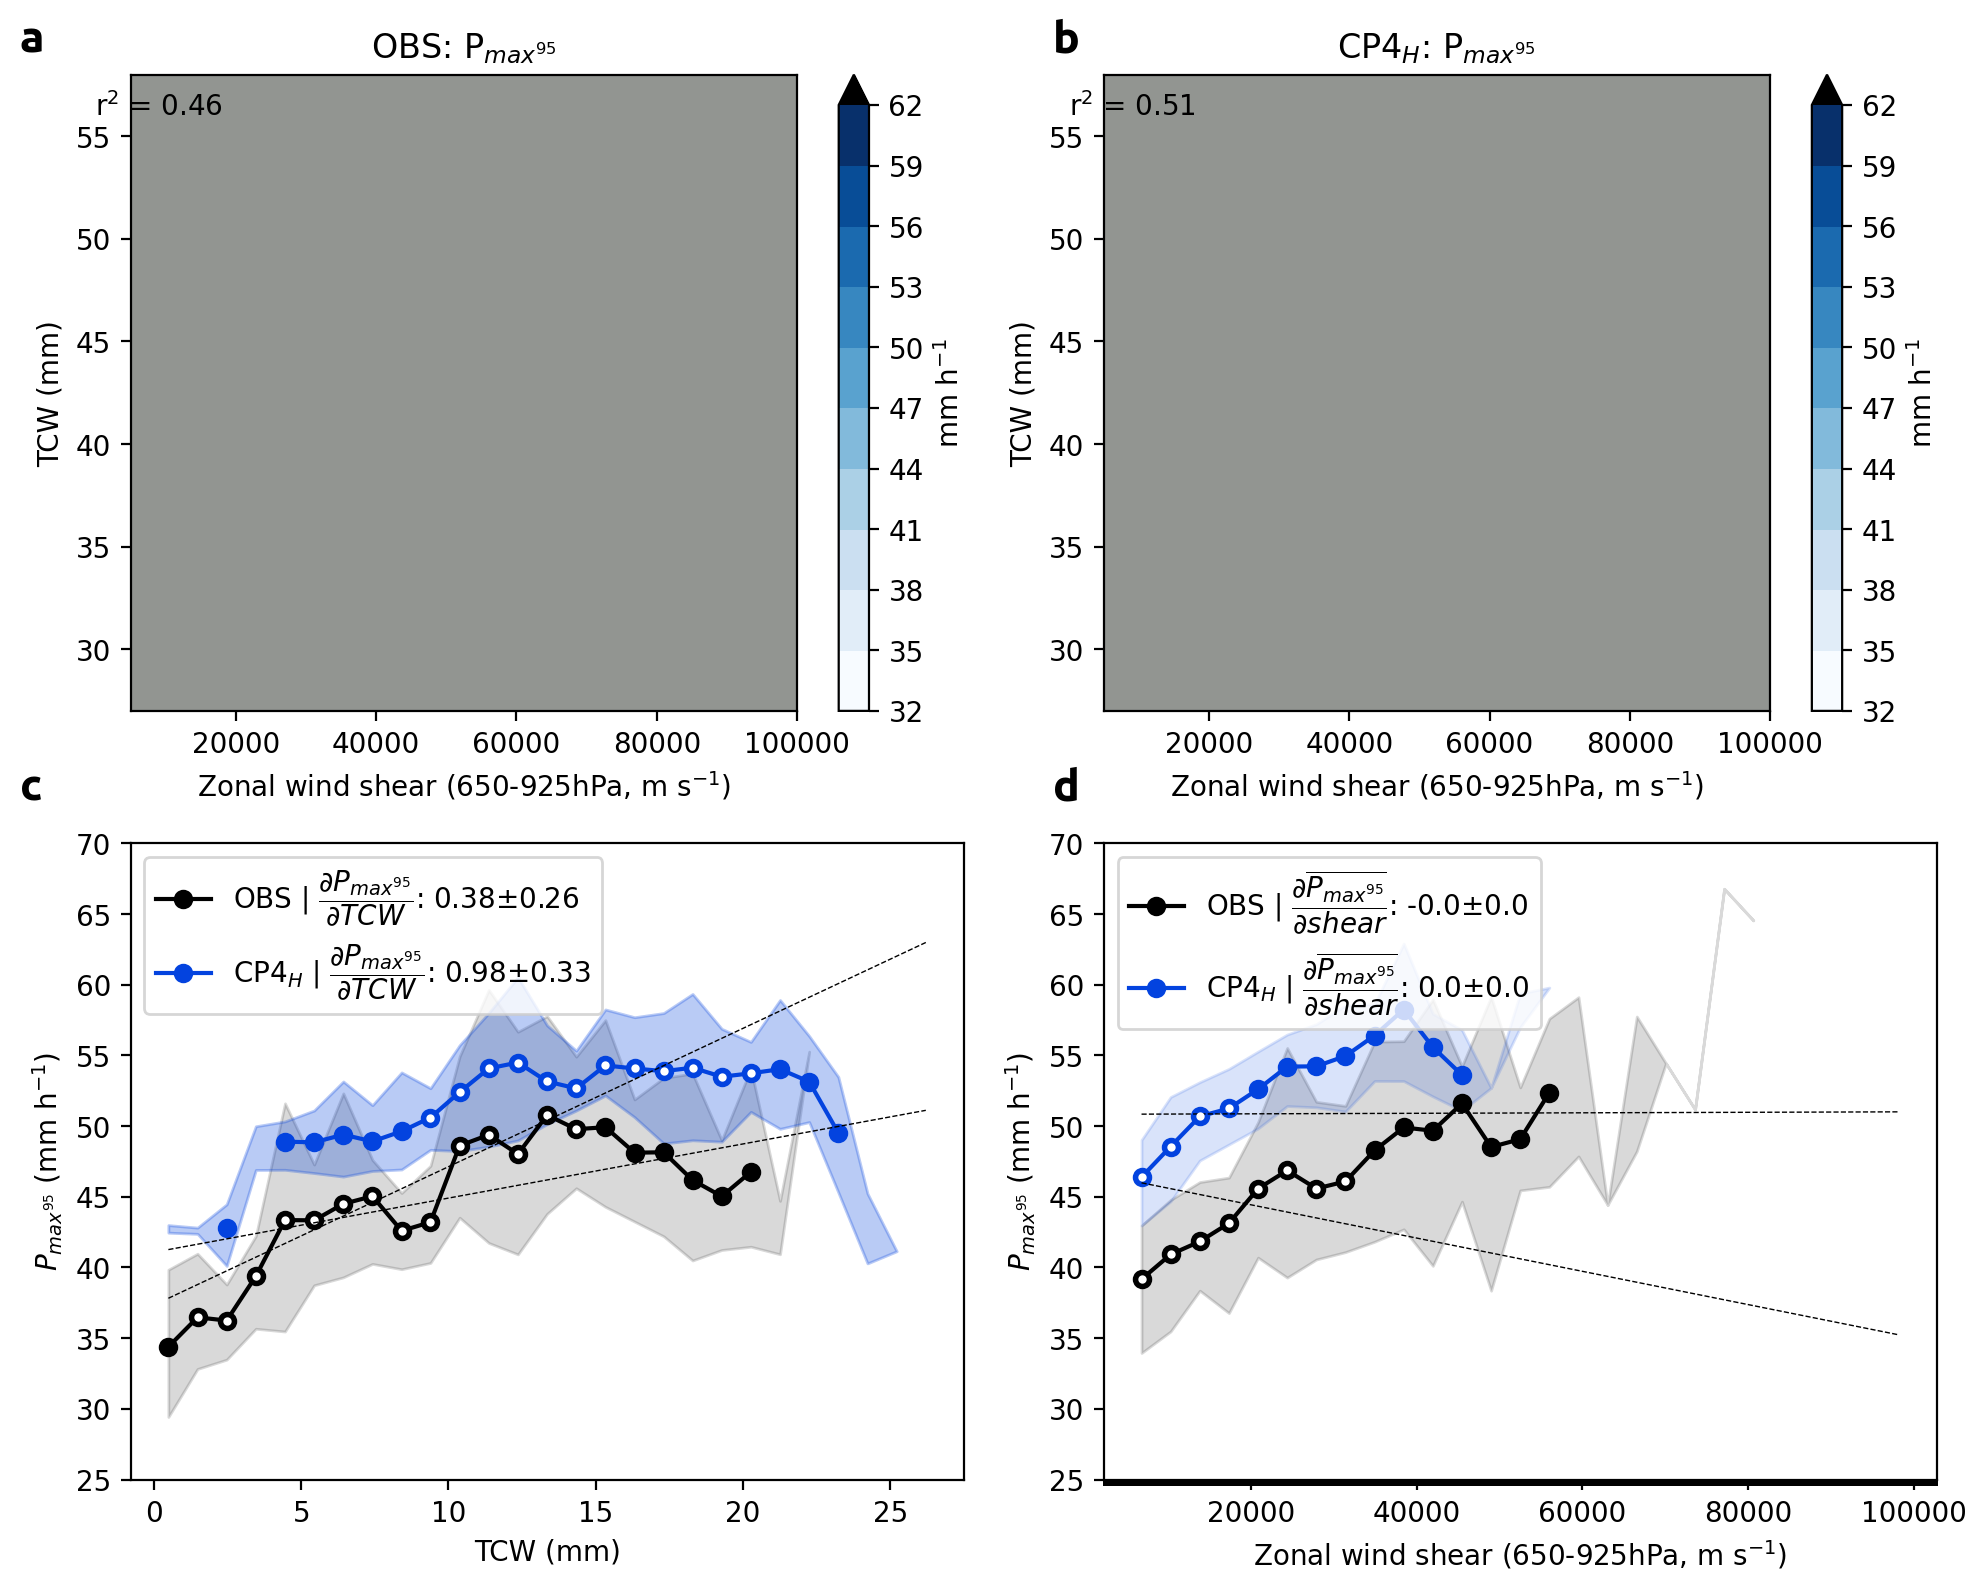

In [269]:
f = plt.figure(figsize=(10,8), dpi=200)
cmap='Blues'
vmins = 32
vmaxs = 62
pixelval = 10
cmapp = uplot.discrete_cmap(10, base_cmap=cmap)
ax = f.add_subplot(2,2,1)
ax.set_facecolor('xkcd:grey')
dd = gauss(ret.statistic.T, 0.8)
invalid = count.statistic.T < pixelval
dd[invalid] = np.nan
bigpos = np.where(dd>60)
print('bigpos', bigpos)
mp = plt.pcolormesh(testbins[0], testbins[1], dd, cmap=cmapp, vmin=vmins, vmax=vmaxs)
#plt.plot(testbins[0][bigpos[1]+1],testbins[1][bigpos[0]+1], 'o', color='grey', ms=1)
ax.set_ylim(27,58)
plt.xlabel('Zonal wind shear (650-925hPa, m s$^{-1}$)')
plt.ylabel('TCW (mm)')
plt.text(1,56, r'r$^2$ = '+str(np.round(dicobs['model'].rsquared,2)), fontsize=10)
plt.title('OBS: P$_{max^{95}}$')

cbar = plt.colorbar(mp, ticks=np.linspace(vmins, vmaxs,11), extend='max')
cbar.set_label('mm h$^{-1}$')

ax = f.add_subplot(2,2,2)
ax.set_facecolor('xkcd:grey')
dd = gauss(ret4.statistic.T, 0.7)
invalid = count4.statistic.T < pixelval
dd[invalid] = np.nan
cmapp.set_over("black")
mp = plt.pcolormesh(testbins[0], testbins[1], dd, cmap=cmapp, vmin=vmins, vmax=vmaxs)
cbar = plt.colorbar(mp, ticks=np.linspace(vmins,vmaxs,11), extend='max')
cbar.set_label('mm h$^{-1}$')
ax.set_ylim(27,58)
plt.xlabel('Zonal wind shear (650-925hPa, m s$^{-1}$)')
plt.ylabel('TCW (mm)')
plt.text(1,56, r'r$^2$ = '+str(np.round(dic4['model'].rsquared,2)), fontsize=10)
plt.title('CP4$_H$: P$_{max^{95}}$')

ax2 = f.add_subplot(223)

ax2.plot(tdicobs['bins'],tdicobs['pmean'], '-ko', label=r'OBS | $\dfrac{\partial P_{max^{95}}}{\partial TCW}$: ' + str(np.round(tdicobs['slope'],2))+r'$\pm$'+str(np.round(tdicobs['model'].bse[1],2)))
ax2.fill_between(tdicobs['bins'],tdicobs['p10'],tdicobs['p90'], color='k', alpha=0.15)
ax2.fill_between(tdic4['bins'],tdic4['p10'],tdic4['p90'], color='xkcd:blue', alpha=0.15)
ax2.plot(tdic4['bins'],tdic4['pmean'], color='xkcd:blue', marker='o', label='CP4$_H$ | $\dfrac{\partial P_{max^{95}}}{\partial TCW}$: ' + str(np.round(tdic4['slope'],2))+'$\pm$'+str(np.round(tdic4['model'].bse[1],2)))

indx = find_cumsum(frac_tcw, 0.8)
ax2.plot(tdicobs['bins'][indx-2],tdicobs['pmean'][indx-2],marker='o', color='white', markersize=2, linestyle='')
indx = find_cumsum(frac4_tcw, 0.8)
ax2.plot(tdic4['bins'][indx],tdic4['pmean'][indx],marker='o', color='white', markersize=2, linestyle='')

#plt.plot(tdicobs['bins'],tdicobs['slope']*tdicobs['bins']+tdicobs['intercept'], linestyle='dashed', color='k', linewidth=0.5)
ax2.plot(tdicobs['bins'],tdicobs['slope']*tdicobs['bins']+tdicobs['intercept'], linestyle='dashed', color='k', linewidth=0.5)
# plt.plot(tdicobs['bins'],(tdicobs['slope']-np.array(dicobs['model'].bse[2]))*tdicobs['bins']+tdicobs['intercept']-dicobs['model'].bse[0], linestyle='dashed', color='k', linewidth=0.5, alpha=0.15)
# plt.plot(tdicobs['bins'],(tdicobs['slope']+np.array(dicobs['model'].bse[2]))*tdicobs['bins']+tdicobs['intercept']+dicobs['model'].bse[0], linestyle='dashed', color='k', linewidth=0.5, alpha=0.15)

ax2.fill_between(tdic4['bins'],tdic4['p10'],tdic4['p90'], color='xkcd:blue', alpha=0.15)


ax2.plot(tdic4['bins'],tdic4['slope']*tdic4['bins']+tdic4['intercept'], linestyle='dashed', color='k', linewidth=0.5)
# ax22 = ax2.twinx()
# ax22.plot(tdic4['bins'], np.sum(count4.statistic.T,axis=1), color='lightblue')

# plt.plot(tdicobs['bins'],tdicobs['slope']*tdicobs['bins']+tdicobs['intercept']+tdicobs['std_est']*2, linestyle='dotted', color='grey', linewidth=0.5)
# plt.plot(tdicobs['bins'],tdicobs['slope']*tdicobs['bins']+tdicobs['intercept']-tdicobs['std_est']*2, linestyle='dotted', color='grey', linewidth=0.5)

# plt.plot(tdic4['bins'],tdic4['slope']*tdic4['bins']+tdic4['intercept']+tdic4['std_est']*2, linestyle='dashed', color='k', linewidth=0.5)
# plt.plot(tdic4['bins'],tdic4['slope']*tdic4['bins']+tdic4['intercept']-tdic4['std_est']*2, linestyle='dashed', color='k', linewidth=0.5)
ax2.set_xlabel('TCW (mm)')
ax2.set_ylabel('$P_{max^{95}}$ (mm h$^{-1}$)')


#plt.title('Zonal wind shear')
#plt.ylim(12,31)
#plt.ylim(15,33)
ax2.set_ylim(25,70)
ax2.xaxis.set_minor_locator(MultipleLocator(5))
ax2.yaxis.set_minor_locator(MultipleLocator(5))
ax2.legend(loc='upper left')
# plt.text(50,28, r'SE$_{OBS} = $'+str(np.round(tdicobs['std_est'],2)), fontsize=10)
# plt.text(50,26, r'SE$_{CP4_H} = $'+str(np.round(tdic4['std_est'],2)), fontsize=10)




ax3 = f.add_subplot(224)
plt.plot(sdicobs['bins'],sdicobs['pmean'], '-ko', label=r'OBS | $\dfrac{\partial \overline{P_{max^{95}}}}{\partial shear}$: ' + str(np.round(sdicobs['slope'],2))+'$\pm$'+str(np.round(sdicobs['model'].bse[1],2)))
plt.fill_between(sdicobs['bins'],sdicobs['p10'],sdicobs['p90'], color='k', alpha=0.15)
plt.fill_between(sdic4['bins'],sdic4['p10'],sdic4['p90'], color='xkcd:blue', alpha=0.15)

plt.plot(sdic4['bins'],sdic4['pmean'], color='xkcd:blue', marker='o', label=r'CP4$_{H}$ | $\dfrac{\partial \overline{P_{max^{95}}}}{\partial shear}$: ' + str(np.round(sdic4['slope'],2))+'$\pm$'+str(np.round(sdic4['model'].bse[1],2)))
#plt.plot(sdicobs['bins'],sdicobs['slope']*sdicobs['bins']+sdicobs['intercept'], linestyle='dashed', color='k', linewidth=0.5)
plt.plot(sdicobs['bins'],sdicobs['slope']*sdicobs['bins']+sdicobs['intercept'], linestyle='dashed', color='k', linewidth=0.5)


plt.plot(sdic4['bins'],sdic4['slope']*sdic4['bins']+sdic4['intercept'], linestyle='dashed', color='k', linewidth=0.5)

indx = find_cumsum(frac_shear, 0.8)
plt.plot(sdicobs['bins'][indx],sdicobs['pmean'][indx],marker='o', color='white', markersize=2, linestyle='')
indx = find_cumsum(frac4_shear, 0.8)
plt.plot(sdic4['bins'][indx],sdic4['pmean'][indx],marker='o', color='white', markersize=2, linestyle='')

fdic = {'obs_shear' : sdicobs['slope'], 'cp4_shear' : sdic4['slope'], 'SE' : sdicobs['model'].bse[1]}
import pickle
pickle.dump(fdic, open('/home/ck/DIR/cornkle/figs/ENDGAME/shear_factors_small.p', "wb"))

#plt.xlabel('Specific humidity (925hPa, g kg$^{-1}$)')

plt.xlabel('Zonal wind shear (650-925hPa, m s$^{-1}$)')
plt.ylabel('$P_{max^{95}}$ (mm h$^{-1}$)')
#plt.title('Total column water vapour')
plt.legend(loc='upper left')
# plt.text(21,28, r'SE$_{OBS} = $'+str(np.round(dicobs['model'].bse[1],2)), fontsize=10)
# plt.text(21,26, r'SE$_{CP4_H} = $'+str(np.round(dic4['model'].bse[1],2)), fontsize=10)
# plt.text(21,28, r'SE$_{OBS} = $'+str(np.round(dicobs['model'].bse[0],2)), fontsize=10)
# plt.text(21,26, r'SE$_{CP4_H} = $'+str(np.round(sdic4['std_est'],2)), fontsize=10)
plt.tight_layout()
plt.ylim(25,70)
ax3.xaxis.set_minor_locator(MultipleLocator(5))
ax3.yaxis.set_minor_locator(MultipleLocator(5))


text = ['a', 'b', 'c', 'd']
plt.annotate(text[0], xy=(0.01, 0.96), xytext=(0, 4), xycoords=('figure fraction', 'figure fraction'),
             textcoords='offset points', fontweight='bold', fontname='Ubuntu', fontsize=16)
plt.annotate(text[1], xy=(0.53, 0.96), xytext=(0, 4), xycoords=('figure fraction', 'figure fraction'),
             textcoords='offset points', fontweight='bold', fontname='Ubuntu', fontsize=16)
plt.annotate(text[2], xy=(0.01, 0.49), xytext=(0, 4), xycoords=('figure fraction', 'figure fraction'),
             textcoords='offset points', fontweight='bold', fontname='Ubuntu', fontsize=16)
plt.annotate(text[3], xy=(0.53, 0.49), xytext=(0, 4), xycoords=('figure fraction', 'figure fraction'),
             textcoords='offset points', fontweight='bold', fontname='Ubuntu', fontsize=16)


#plt.savefig(cnst.network_data + 'figs/ENDGAME/OBS_CP4_2dHist_'+tag+'_15km_'+ttag+'_NOFUTURE_50Cp90_duo_gauss_hourly2_8mm_new_modelR2.jpg')

In [ ]:
f = plt.figure(figsize=(10,8), dpi=200)
cmap='Blues'
vmins = 5
vmaxs = 32
pixelval = 10
cmapp = uplot.discrete_cmap(10, base_cmap=cmap)
ax = f.add_subplot(2,2,1)
ax.set_facecolor('xkcd:grey')
dd = thresh.statistic.T
invalid = count.statistic.T < pixelval
dd[invalid] = np.nan


dd = dd/count.statistic.T*100
#dd = gauss(dd, 0.5)

bigpos = np.where(dd>60)
print('bigpos', bigpos)
mp = plt.pcolormesh(testbins[0], testbins[1], dd, cmap=cmapp, vmin=vmins, vmax=vmaxs)
#plt.plot(testbins[0][bigpos[1]+1],testbins[1][bigpos[0]+1], 'o', color='grey', ms=1)
ax.set_ylim(27,58)
plt.xlabel('Zonal wind shear (650-925hPa, m s$^{-1}$)')
plt.ylabel('TCW (mm)')
plt.text(1,56, r'r$^2$ = '+str(np.round(dicobs['model'].rsquared,2)), fontsize=10)
plt.title('OBS: P$_{max^{95}}$')

cbar = plt.colorbar(mp, ticks=np.linspace(vmins, vmaxs,11), extend='max')
cbar.set_label('mm h$^{-1}$')

ax = f.add_subplot(2,2,2)
ax.set_facecolor('xkcd:grey')
dd = gauss(ret4.statistic.T, 0.7)
invalid = count4.statistic.T < pixelval
dd[invalid] = np.nan
cmapp.set_over("black")
mp = plt.pcolormesh(testbins[0], testbins[1], dd, cmap=cmapp, vmin=vmins, vmax=vmaxs)
cbar = plt.colorbar(mp, ticks=np.linspace(vmins,vmaxs,11), extend='max')
cbar.set_label('mm h$^{-1}$')
ax.set_ylim(27,58)
plt.xlabel('Zonal wind shear (650-925hPa, m s$^{-1}$)')
plt.ylabel('TCW (mm)')
plt.text(1,56, r'r$^2$ = '+str(np.round(dic4['model'].rsquared,2)), fontsize=10)
plt.title('CP4$_H$: P$_{max^{95}}$')

ax2 = f.add_subplot(223)
plt.plot(tdicobs['bins'],tdicobs['valid'], '-ko', label=r'OBS | $\dfrac{\partial P_{max^{95}}}{\partial TCW}$: ' + str(np.round(tdicobs['slope'],2))+r'$\pm$'+str(np.round(dicobs['model'].bse[2],2)))
# plt.fill_between(tdicobs['bins'],tdicobs['p10'],tdicobs['p90'], color='k', alpha=0.15)
# plt.fill_between(tdic4['bins'],tdic4['p10'],tdic4['p90'], color='xkcd:blue', alpha=0.15)
plt.plot(tdic4['bins'],tdic4['valid'], color='xkcd:blue', marker='o', label='CP4$_H$ | $\dfrac{\partial P_{max^{95}}}{\partial TCW}$: ' + str(np.round(tdic4['slope'],2))+'$\pm$'+str(np.round(dic4['model'].bse[2],2)))


#plt.plot(tdicobs['bins'],tdicobs['slope']*tdicobs['bins']+tdicobs['intercept'], linestyle='dashed', color='k', linewidth=0.5)
#plt.plot(tdicobs['bins'],tdicobs['slope']*tdicobs['bins']+tdicobs['intercept'], linestyle='dashed', color='k', linewidth=0.5)
# plt.plot(tdicobs['bins'],(tdicobs['slope']-np.array(dicobs['model'].bse[2]))*tdicobs['bins']+tdicobs['intercept']-dicobs['model'].bse[0], linestyle='dashed', color='k', linewidth=0.5, alpha=0.15)
# plt.plot(tdicobs['bins'],(tdicobs['slope']+np.array(dicobs['model'].bse[2]))*tdicobs['bins']+tdicobs['intercept']+dicobs['model'].bse[0], linestyle='dashed', color='k', linewidth=0.5, alpha=0.15)

#plt.fill_between(tdic4['bins'],tdic4['p10'],tdic4['p90'], color='xkcd:blue', alpha=0.15)


#plt.plot(tdic4['bins'],tdic4['slope']*tdic4['bins']+tdic4['intercept'], linestyle='dashed', color='k', linewidth=0.5)

# plt.plot(tdicobs['bins'],tdicobs['slope']*tdicobs['bins']+tdicobs['intercept']+tdicobs['std_est']*2, linestyle='dotted', color='grey', linewidth=0.5)
# plt.plot(tdicobs['bins'],tdicobs['slope']*tdicobs['bins']+tdicobs['intercept']-tdicobs['std_est']*2, linestyle='dotted', color='grey', linewidth=0.5)

# plt.plot(tdic4['bins'],tdic4['slope']*tdic4['bins']+tdic4['intercept']+tdic4['std_est']*2, linestyle='dashed', color='k', linewidth=0.5)
# plt.plot(tdic4['bins'],tdic4['slope']*tdic4['bins']+tdic4['intercept']-tdic4['std_est']*2, linestyle='dashed', color='k', linewidth=0.5)
plt.xlabel('TCW (mm)')
plt.ylabel('$P_{max^{95}}$ (mm h$^{-1}$)')


#plt.title('Zonal wind shear')
#plt.ylim(12,31)
#plt.ylim(15,33)
#plt.ylim(25,70)
ax2.xaxis.set_minor_locator(MultipleLocator(5))
ax2.yaxis.set_minor_locator(MultipleLocator(5))
plt.legend(loc='upper left')
# plt.text(50,28, r'SE$_{OBS} = $'+str(np.round(tdicobs['std_est'],2)), fontsize=10)
# plt.text(50,26, r'SE$_{CP4_H} = $'+str(np.round(tdic4['std_est'],2)), fontsize=10)




ax3 = f.add_subplot(224)
plt.plot(sdicobs['bins'],sdicobs['valid'], '-ko', label=r'OBS | $\dfrac{\partial \overline{P_{max^{95}}}}{\partial shear}$: ' + str(np.round(sdicobs['slope'],2))+'$\pm$'+str(np.round(dicobs['model'].bse[1],2)))
# plt.fill_between(sdicobs['bins'],sdicobs['p10'],sdicobs['p90'], color='k', alpha=0.15)
# plt.fill_between(sdic4['bins'],sdic4['p10'],sdic4['p90'], color='xkcd:blue', alpha=0.15)

plt.plot(sdic4['bins'],sdic4['valid'], color='xkcd:blue', marker='o', label=r'CP4$_{H}$ | $\dfrac{\partial \overline{P_{max^{95}}}}{\partial shear}$: ' + str(np.round(sdic4['slope'],2))+'$\pm$'+str(np.round(dic4['model'].bse[1],2)))
#plt.plot(sdicobs['bins'],sdicobs['slope']*sdicobs['bins']+sdicobs['intercept'], linestyle='dashed', color='k', linewidth=0.5)
#plt.plot(sdicobs['bins'],sdicobs['slope']*sdicobs['bins']+sdicobs['intercept'], linestyle='dashed', color='k', linewidth=0.5)


#plt.plot(sdic4['bins'],sdic4['slope']*sdic4['bins']+sdic4['intercept'], linestyle='dashed', color='k', linewidth=0.5)

fdic = {'obs_shear' : sdicobs['slope'], 'cp4_shear' : sdic4['slope']}
import pickle
pickle.dump(fdic, open('/home/ck/DIR/cornkle/figs/ENDGAME/shear_factors_small.p', "wb"))

#plt.xlabel('Specific humidity (925hPa, g kg$^{-1}$)')

plt.xlabel('Zonal wind shear (650-925hPa, m s$^{-1}$)')
plt.ylabel('$P_{max^{95}}$ (mm h$^{-1}$)')
#plt.title('Total column water vapour')
plt.legend(loc='upper left')
# plt.text(21,28, r'SE$_{OBS} = $'+str(np.round(dicobs['model'].bse[0],2)), fontsize=10)
# plt.text(21,26, r'SE$_{CP4_H} = $'+str(np.round(sdic4['std_est'],2)), fontsize=10)
plt.tight_layout()
#plt.ylim(25,70)
ax3.xaxis.set_minor_locator(MultipleLocator(5))
ax3.yaxis.set_minor_locator(MultipleLocator(5))


text = ['a', 'b', 'c', 'd']
plt.annotate(text[0], xy=(0.01, 0.96), xytext=(0, 4), xycoords=('figure fraction', 'figure fraction'),
             textcoords='offset points', fontweight='bold', fontname='Ubuntu', fontsize=16)
plt.annotate(text[1], xy=(0.53, 0.96), xytext=(0, 4), xycoords=('figure fraction', 'figure fraction'),
             textcoords='offset points', fontweight='bold', fontname='Ubuntu', fontsize=16)
plt.annotate(text[2], xy=(0.01, 0.49), xytext=(0, 4), xycoords=('figure fraction', 'figure fraction'),
             textcoords='offset points', fontweight='bold', fontname='Ubuntu', fontsize=16)
plt.annotate(text[3], xy=(0.53, 0.49), xytext=(0, 4), xycoords=('figure fraction', 'figure fraction'),
             textcoords='offset points', fontweight='bold', fontname='Ubuntu', fontsize=16)


#plt.savefig(cnst.network_data + 'figs/ENDGAME/OBS_CP4_2dHist_'+tag+'_15km_'+ttag+'_NOFUTURE_50Cp90_duo_gauss_hourly2_8mm_new.jpg')

bigpos (array([], dtype=int64), array([], dtype=int64))


/home/ck/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:15: RuntimeWarning: invalid value encountered in true_divide
  from ipykernel import kernelapp as app


Text(0, 4, 'd')

Locator attempting to generate 20127 ticks ([2185.0, ..., 102815.0]), which exceeds Locator.MAXTICKS (1000).
